![](https://www.nuplan.org/static/media/nuPlan_final.3fde7586.png)

### Contents

1. [Introduction to nuPlan](#introduction)
2. [Training an ML planner](#training)
3. [Simulating a planner](#simulation)
4. [Visualizing metrics and scenarios](#dashboard)

# Introduction to nuPlan <a name="introduction"></a>


Welcome to nuPlan! This notebook will explore the nuPlan simulation framework, training platform as well as the nuBoard metrics/scenarios visualization dashboard.

## What is nuPlan

nuPlan is the world’s first closed-loop ML-based planning benchmark for autonomous driving.

It provides a high quality dataset with 1500h of human driving data from 4 cities across the US and Asia with widely varying traffic patterns (Boston, Pittsburgh, Las Vegas and Singapore). In addition, it provides a closed-loop simulation framework with reactive agents, a training platform as well as a large set of both general and scenario-specific planning metrics.

![](https://www.nuscenes.org/static/media/framework_steps.2d4642df.png)

## Training & simulation framework

The nuPlan training and simulation framework aims to:
* create a simulation pipeline to evaluate a planner on large dataset with various scenarios
* score planner performance with common and scenario-dependent metrics
* compare planners based on measured metrics and provide intuitive visualizations
* train planners with the provided framework to allow quick implementation and iteration
* support closed-loop simulation and training

<br />

![](https://www.nuplan.org/static/media/planning_framework.ca3c2969.png)

## Scenarios in nuPlan

nuPlan aims to capture challenging yet representative scenarios from real-world encounters. This enables the benchmarking of planning systems both in expert imitation (open-loop) and reactive planning (closed-loop) settings.

These scenarios includes:
* highly interactive scenes with traffic participants (e.g. tailgating, high-velocity overtakes, double parked cars, jaywalking)
* various ego behaviors (e.g. vehicle following, yielding, lane merging) and dynamics (e.g. mixed speed profiles, abrupt braking, speed bumps, high jerk maneuvers)
* scene layouts of varied complexity (e.g. pudos, traffic/stop controlled intersections, unprotected turns) and temporary zones (e.g. construction areas)

The dataset is automatically tagged with scenario labels based on certain primitive attributes.
These scenario tags can then be used to extract representative metrics for the planner's evaluation.

Example mined scenarios in nuPlan:

| | | |
| :-: | :-: | :-: |
| Unprotected cross turn | Dense vehicle interactions | Jaywalker in front |
| ![](https://www.nuscenes.org/static/media/unprotected-cross.51feef7e.webp) | ![](https://www.nuscenes.org/static/media/dense-interactions.16de47ec.webp) | ![](https://www.nuscenes.org/static/media/jaywalker.03083823.webp) |
| Lane change | Ego at pickup/dropoff area | Ego following vehicle |
| ![](https://www.nuscenes.org/static/media/lane-change.54bfca1c.webp) | ![](https://www.nuscenes.org/static/media/pickup-dropoff.4dd1c418.webp) | ![](https://www.nuscenes.org/static/media/following-vehicle.4cacd559.webp) |

## Database

Download a database for training/simulation from [here](https://nuplan.org/nuplan#download).

| Database | Size | Duration | Num Logs | Cities | Num Scenarios | Sensor Data | Description |
| :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- |
| nuplan_v1.1_mini (recommended) | 13GB | 7h | 64 | Las Vegas, Boston, Pittsburgh, Singapore | 67 | N/A | The mini split used for prototyping and testing |
| nuplan_v1.1 | 1.8TB | ~1300h | 15910 | Las Vegas, Boston, Pittsburgh, Singapore | 73 | N/A | The full dataset for training and evaluation|

## Setup

To be able to access all resources within this notebook, make sure Jupyter is launched at the root of this repo. The path of the notebook should be `/notebook/<repo_root>`.

In [1]:
# (Optional) Increase notebook width for all embedded cells to display properly
from IPython.core.display import display, HTML
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_126900/4180358289.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Useful imports
import os
from pathlib import Path
import tempfile

import hydra

# Training an ML planner <a name="training"></a>

## Imitation learning
In the following section we will train an ML planning policy with the aim estimate the ego's future trajectory and control the vehicle.

The policy is learned through imitation learning, a supervised learning approach in which - in the context of autonomous driving - the behavior of an expert human driver is used as a target signal to supervise the model.

## Model features & targets
A planning policy consumes a set of episodic observations and encodes them through a deep neural network to regress a future trajectory.

The observations can be historic or present ego and agent poses as well as static/dynamic map information across different map layers.<br />
These signals can be encoded through various representations, such as raster or vector format for the map signal, each with their pros and cons for each model flavor.

Using these input features the model predicts a discretized future trajectory across a fixed time horizon.<br />
The trajectory consists of a set of discrete future states (position, heading and velocity) sampled at fixed intervals which express the likelihood of the vehicle being at that state in the future.<br />
For example, a predicted trajectory may consist of 10 future poses sampled at intervals of 0.5s across a 5s horizon.

## Learning objectives
The policy is trained to maximize a set of aggregated objectives such as imitation, collision avoidance, traffic rule violation etc.<br />
Imitation is the core training objective which indicates how close the predicted trajectory is to the expert ground truth and penalizes model predictions that deviate in space and time from the demonstration.

## Training parameters

The following parameter categories define the training protocol which includes the model, metrics, objectives etc.

A working example composition of these parameters can be found in the next section.

---

### ML models

Change the training model with `model=X` where `X` is a config yaml defined in the table below. 

| Model | Description | Config |
| --- | --- | --- |
| Raster model (CNN) | Raster-based model that uses a CNN backbone to encode ego, agent and map information as raster layers<br />Any (pretrained) backbone from the TIMM library can be used (e.g. ResNet50, EfficientNetB3) | `raster_model` |
| Vector model (LaneGCN) | Vector-based model that uses a series of MLPs to encode ego and agent signals, a lane graph to encode vector-map elements and a fusion network to capture lane & agent intra/inter-interactions through attention layers<br />Implementation of LaneGCN paper ("Learning Lane Graph Representations for Motion Forecasting") | `vector_model` |
| Simple vector model | Toy vector-based model that consumes ego, agent and lane signals through a series of MLPs | `simple_vector_model` |

<br />

### Training objectives

Change the training objectives with `objective=[X, ...]` where `X` is a config yaml defined in the table below. 

| Objective | Description | Config |
| --- | --- | --- |
| Imitation objective | Penalizes the predicted trajectory that deviates from the expert demonstration | `imitation_objective` |

<br />

### Training metrics

Change the training objectives with `training_metric=[X, ...]` where `X` is a config yaml defined in the table below. 

| Metric | Description | Config |
| --- | --- | --- |
| Average displacement error | RMSE translation error across full predicted trajectory | `avg_displacement_error` |
| Average heading error | RMSE heading error across full predicted trajectory | `avg_heading_error` |
| Final displacement error | L2 error of predicted trajectory's final pose translation | `final_displacement_error` |
| Final heading error | L2 error of predicted trajectory's final pose heading | `final_heading_error` |

## Prepare the training config

In [3]:
# Location of path with all training configs
CONFIG_PATH = '../nuplan/planning/script/config/training'
CONFIG_NAME = 'default_training'

# Create a temporary directory to store the cache and experiment artifacts
# SAVE_DIR = Path(tempfile.gettempdir()) / 'tutorial_nuplan_framework'  # optionally replace with persistent dir
SAVE_DIR = Path('/hdd/vladislav/nuplan-results')
EXPERIMENT = 'training_raster_experiment'
JOB_NAME = 'train_default_raster'
LOG_DIR = str(SAVE_DIR / EXPERIMENT / JOB_NAME)

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    f'group={str(SAVE_DIR)}',
    f'cache.cache_path={str(SAVE_DIR)}/cache',
    f'experiment_name={EXPERIMENT}',
    f'job_name={JOB_NAME}',
    'py_func=train',
    '+training=training_raster_model',  # raster model that consumes ego, agents and map raster layers and regresses the ego's trajectory
    'scenario_builder=nuplan_mini',  # use nuplan mini database
    'scenario_filter.limit_total_scenarios=500',  # Choose 500 scenarios to train with
    'lightning.trainer.params.accelerator=ddp_spawn',  # ddp is not allowed in interactive environment, using ddp_spawn instead - this can bottleneck the data pipeline, it is recommended to run training outside the notebook
    'lightning.trainer.params.max_epochs=10',
    'data_loader.params.batch_size=8',
    'data_loader.params.num_workers=8',
])


## Launch tensorboard for visualizing training artifacts

In [4]:
%load_ext tensorboard
%tensorboard --logdir {LOG_DIR}

## Launch training (within the notebook)

In [4]:
from nuplan.planning.script.run_training import main as main_train

# Run the training loop, optionally inspect training artifacts through tensorboard (above cell)
main_train(cfg)

Global seed set to 0


2023-03-26 16:11:14,818 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:17}  Building experiment folders...
2023-03-26 16:11:14,819 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:19}  Experimental folder: /hdd/vladislav/nuplan-results/training_raster_experiment/train_default_raster/2023.03.26.16.11.14
2023-03-26 16:11:14,819 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-03-26 16:11:14,820 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:75}  Starting ray local!


2023-03-26 16:11:16,714	INFO worker.py:1553 -- Started a local Ray instance.


2023-03-26 16:11:17,672 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2023-03-26 16:11:17,673 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 12
Number of GPUs per node: 1
Number of threads across all nodes: 12
2023-03-26 16:11:17,673 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2023-03-26 16:11:17,673 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/training/experiments/training.py:41}  Building training engine...
2023-03-26 16:11:17,674 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-03-26 16:11:18,282 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch

Ray objects: 100%|███████████████████████████████████████████████████████| 12/12 [00:10<00:00,  1.14it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
Global seed set to 0
initializing ddp: GLOBAL_RANK: 0, MEMBER: 1/1
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All DDP processes registered. Starting ddp with 1 processes
----------------------------------------------------------------------------------------------------



2023-03-26 16:11:29,865 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/scenario_builder.py:170}  Extracted 500 scenarios for training
2023-03-26 16:11:29,865 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/training/experiments/training.py:52}  Updating configs based on ddp_spawn strategy is currently not supported. Optimizer and LR Scheduler configs will not be updated.
2023-03-26 16:11:29,868 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/training_callback_builder.py:19}  Building callbacks...
2023-03-26 16:11:29,943 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/training_callback_builder.py:37}  Building callbacks...DONE!
2023-03-26 16:11:29,947 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/run_training.py:62}  Starting training...
2023-03-26 16:11:30,003 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/torch/distributed/distributed_c10d.py:194}  Added key: store_based_barrier_key:1 to s

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | RasterModel | 23.6 M
--------------------------------------
23.6 M    Trainable params
0         Non-trainable params
23.6 M    Total params
94.438    Total estimated model params size (MB)


2023-03-26 16:11:34,762 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/training/data_loader/datamodule.py:47}  Number of samples in train set: 323
2023-03-26 16:11:34,763 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/training/data_loader/datamodule.py:47}  Number of samples in validation set: 81
2023-03-26 16:11:34,765 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/training/modeling/lightning_module_wrapper.py:196}  Using optimizer: torch.optim.Adam
2023-03-26 16:11:34,766 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/lr_scheduler_builder.py:52}  Not using any lr_schedulers.


/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:73: UserWarning: num_workers>0, persistent_workers=False, and accelerator=ddp_spawn may result in data loading bottlenecks. Consider setting persistent_workers=True (this is a limitation of Python .spawn() and PyTorch)
  rank_zero_warn(
/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/pytorch_lightning/callbacks/lr_monitor.py:97: RuntimeWarning: You are using `LearningRateMonitor` callback with models that have no learning rate schedulers. Please see documentation for `configure_optimizers` method.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


2023-03-26 16:11:35,871 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/torch/nn/parallel/distributed.py:788}  Reducer buckets have been rebuilt in this iteration.


(raylet) [2023-03-26 16:11:36,612 E 121002 121036] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_16-11-14_839593_120779 is over 95% full, available space: 13281083392; capacity: 490577010688. Object creation will fail if spilling is required.
/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/pytorch_lightning/trainer/callback_hook.py:100: LightningDeprecationWarning: The signature of `Callback.on_train_epoch_end` has changed in v1.3. `outputs` parameter has been removed. Support for the old signature will be removed in v1.5
  warning_cache.deprecation(


Validating: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
/hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
  re

Validating: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Validating: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Validating: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Validating: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Validating: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Validating: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
(raylet) [2023-03-26 16:12:36,638 E 121002 121036] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_16-11-14_839593_120779 is over 95% full, available space: 13280759808; capacity: 490577010688. Object creation will fail if spilling is required.
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-po

Validating: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
(raylet) [2023-03-26 16:12:46,

Validating: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Validating: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

## Launch training (command line - alternative)

A training experiment with the above same parameters can be launched alternatively with:
```
$ python nuplan/planning/script/run_training.py \
    experiment_name=raster_experiment \
    py_func=train \
    +training=training_raster_model \
    scenario_builder=nuplan_mini \
    scenario_filter.limit_total_scenarios=500 \
    lightning.trainer.params.max_epochs=10 \
    data_loader.params.batch_size=8 \
    data_loader.params.num_workers=8
```

# Simulating a planner <a name="simulation"></a>

## Open-loop simulation
Open-loop simulation aims to evaluate the policy's capabilities to imitate the expert driver's behavior.<br />
This is essentially done through log replay as the policy's predictions do not affect the state of the simulation.

As the policy is not in full control of the vehicle, this type of simulation can only provide a high-level performance overview.

## Closed-loop simulation
Conversely, in closed-loop simulation the policy's actions alter the state of the simulation which tries to closely approximate the real-world system.

The simulation's feedback loop enables a more in-depth evaluation of the policy as compounding errors can cause future observations to significantly diverge from the ground truth.<br />
This is important in measuring distribution shifts introduced due to lack of variance in training examples through pure imitation learning.

Closed-loop simulation is further divided into two categories:
* ego closed-loop simulation with agents replayed from log (open-loop, non reactive)
* ego closed-loop simulation with agents controlled by a rule-based or learned policy (closed-loop, reactive)

## Measuring success
Measuring the success of a planning task and comparing various planning policies is a complicated effort that involves defining metrics across different vertical dimensions and scenario categories.<br />
These metrics include indicators such as vehicle dynamics, traffic rule violations, expert imitation, navigation success etc.<br />
Overall, they aim to capture the policy's ability to control the autonomous vehicle safely yet efficiently without compromising the passenger's comfort.

## Simulation parameters

### Planners

Change the planner model with `planner=X` where `X` is a config yaml defined in the table below. 

| Planner | Description | Config |
| --- | --- | --- |
| Simple Planner | Naive planner that only plans a straight path | `simple_planner` |
| ML Planner | Learning-based planner trained using the nuPlan training framework (see previous section) | `ml_planner` |

## Prepare the simulation config

In [4]:
# Location of path with all simulation configs
CONFIG_PATH = '../nuplan/planning/script/config/simulation'
CONFIG_NAME = 'default_simulation'

# Select the planner and simulation challenge
PLANNER = 'idm_planner' #'simple_planner'  # [simple_planner, ml_planner]
CHALLENGE = 'closed_loop_reactive_agents'  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents]
DATASET_PARAMS = [
    'scenario_builder=nuplan_mini',  # use nuplan mini database
    'scenario_filter=all_scenarios',  # initially select all scenarios in the database
    'scenario_filter.scenario_types=[starting_straight_traffic_light_intersection_traversal, high_lateral_acceleration, changing_lane, high_magnitude_speed, low_magnitude_speed, starting_left_turn, starting_right_turn, stopping_with_lead, following_lane_with_lead, near_multiple_vehicles, traversing_pickup_dropoff, behind_long_vehicle, waiting_for_pedestrian_to_cross, stationary_in_traffic]',  # select scenario types
    'scenario_filter.num_scenarios_per_type=10',  # use 10 scenarios per scenario type
]

# Name of the experiment
EXPERIMENT = 'IDM_experiment_closed_loop_reactive'

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    f'experiment_name={EXPERIMENT}',
    f'group={SAVE_DIR}',
    f'planner={PLANNER}',
    f'+simulation={CHALLENGE}',
    *DATASET_PARAMS,
])

## Launch simulation (within the notebook)

Global seed set to 0
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback...
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback: 4...DONE!


2023-03-26 19:07:03,863 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-03-26 19:07:03,914 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:75}  Starting ray local!


2023-03-26 19:07:05,801	INFO worker.py:1553 -- Started a local Ray instance.


2023-03-26 19:07:06,745 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2023-03-26 19:07:06,746 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 12
Number of GPUs per node: 1
Number of threads across all nodes: 12
2023-03-26 19:07:06,746 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2023-03-26 19:07:06,746 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:29}  Building experiment folders...
2023-03-26 19:07:06,746 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  

	Folder where all results are stored: /hdd/vladislav/nuplan-results/IDM_experiment_closed_loop_reactive/closed_loop_reactive_agents/2023.03.26.19.07.03

2023-03-26 19:07:06,746 INFO {/hdd/vladislav/nuplan-devkit/nuplan/pla

Ray objects: 100%|███████████████████████████████████████████████████████| 12/12 [00:12<00:00,  1.04s/it]


2023-03-26 19:07:19,627 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:55}  Extracting scenarios 140...DONE!
2023-03-26 19:07:19,627 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:59}  Building metric engines...
2023-03-26 19:07:20,901 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:61}  Building metric engines...DONE
2023-03-26 19:07:20,901 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:65}  Building simulations from 140 scenarios...
2023-03-26 19:07:24,772 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:121}  Building simulations...DONE!
2023-03-26 19:07:24,772 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/run_simulation.py:80}  Running simulation...
2023-03-26 19:07:24,772 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/utils.py:135}  Executing runners...
2

Converting detections to smart agents:   0%|          | 0/1 [00:00<?, ?it/s]
(wrapped_fn pid=127119) /hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
(wrapped_fn pid=127119)   return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]
                                                                                     
(wrapped_fn pid=127120) /hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
(wrapped_fn pid=127120)   return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]
                                                                                    
(wrapped_fn pid=127113) /hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
(wrapped_fn pid=127113)   return elements.iloc[np.where(ele

Converting detections to smart agents:  20%|██        | 4/20 [00:08<00:21,  1.32s/it]
                                                                                      
(wrapped_fn pid=127121) /hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
(wrapped_fn pid=127121)   return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]
Converting detections to smart agents:  76%|███████▌  | 28/37 [00:08<00:01,  6.29it/s]
(wrapped_fn pid=127114) /hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
(wrapped_fn pid=127114)   return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]
(wrapped_fn pid=127121) /hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
(wrapped_fn pid=127121)   return elements.iloc[

(raylet) [2023-03-26 19:08:25,720 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13382057984; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:08:35,722 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13382045696; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:08:45,724 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13382037504; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:08:55,726 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13382033408; capacity: 490577010688. Obj

(raylet) [2023-03-26 19:10:25,755 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13381738496; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:10:35,757 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13381722112; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:10:45,760 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13381709824; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:10:55,762 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13381705728; capacity: 490577010688. Obj

Converting detections to smart agents:  87%|████████▋ | 13/15 [00:00<00:00, 21.31it/s]
(raylet) [2023-03-26 19:12:35,793 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13381451776; capacity: 490577010688. Object creation will fail if spilling is required.
                                                                                      
(wrapped_fn pid=127113) /hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
(wrapped_fn pid=127113)   return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]
Converting detections to smart agents:   3%|▎         | 1/32 [00:07<03:54,  7.57s/it]
(wrapped_fn pid=127113) /hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
(wrapped_fn pid=127113)   return elements.iloc[np.where(el

(raylet) [2023-03-26 19:14:35,840 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13381214208; capacity: 490577010688. Object creation will fail if spilling is required.
Converting detections to smart agents:  14%|█▍        | 2/14 [00:00<00:01,  9.88it/s]
                                                                                     
Converting detections to smart agents:  56%|█████▌    | 23/41 [00:00<00:00, 70.37it/s]
                                                                                      
(raylet) [2023-03-26 19:14:55,845 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13381210112; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:15:05,847 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_93820

Converting detections to smart agents:  91%|█████████▏| 32/35 [00:00<00:00, 37.61it/s]
                                                                                      
Converting detections to smart agents:  88%|████████▊ | 50/57 [00:00<00:00, 52.88it/s]
                                                                                      
Converting detections to smart agents:   0%|          | 0/9 [00:00<?, ?it/s]/140 [10:09<38:18, 19.48s/it](wrapped_fn pid=127121) 
                                                                            
(raylet) [2023-03-26 19:17:35,884 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13380993024; capacity: 490577010688. Object creation will fail if spilling is required.
Converting detections to smart agents:  88%|████████▊ | 23/26 [00:00<00:00, 42.54it/s]
                                                                                      
(wrapped_

(wrapped_fn pid=127116) WARNING:nuplan.planning.simulation.planner.idm_planner:IDMPlanner could not find valid path to the target roadblock. Using longest route found instead
(wrapped_fn pid=127116) /hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
(wrapped_fn pid=127116)   return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]
(raylet) [2023-03-26 19:19:25,911 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13380841472; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:19:35,913 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13380849664; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:19:4

Converting detections to smart agents:  43%|████▎     | 6/14 [00:00<00:00,  9.28it/s]
                                                                                     
Converting detections to smart agents:  96%|█████████▌| 24/25 [00:00<00:00, 32.77it/s]
                                                                                      
(raylet) [2023-03-26 19:22:15,957 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13380591616; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:22:25,960 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13380571136; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:22:35,962 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_93820

(raylet) [2023-03-26 19:24:25,991 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13380415488; capacity: 490577010688. Object creation will fail if spilling is required.
Converting detections to smart agents:  60%|██████    | 30/50 [00:00<00:00, 41.47it/s]
(raylet) [2023-03-26 19:24:35,994 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13380411392; capacity: 490577010688. Object creation will fail if spilling is required.
Converting detections to smart agents:  88%|████████▊ | 44/50 [00:01<00:00, 25.37it/s]
                                                                                      
(raylet) [2023-03-26 19:24:45,997 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13380403200; capacity: 490577010688. Obje

(raylet) [2023-03-26 19:27:06,033 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13380218880; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:27:16,035 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13380161536; capacity: 490577010688. Object creation will fail if spilling is required.
Converting detections to smart agents:  69%|██████▉   | 9/13 [00:00<00:00, 45.15it/s]
                                                                                     
(wrapped_fn pid=127118) WARNING:nuplan.planning.simulation.planner.idm_planner:IDMPlanner could not find valid path to the target roadblock. Using longest route found instead
(raylet) [2023-03-26 19:27:26,038 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_9382

Converting detections to smart agents:   0%|          | 0/10 [00:00<?, ?it/s]140 [22:03<26:35, 19.22s/it](wrapped_fn pid=127117) 
(wrapped_fn pid=127117) /hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
(wrapped_fn pid=127117)   return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]
Converting detections to smart agents:  30%|███       | 3/10 [00:03<00:06,  1.08it/s]/hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
(wrapped_fn pid=127117)   return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]
                                                                                     
(wrapped_fn pid=127117) WARNING:nuplan.planning.simulation.planner.idm_planner:IDMPlanner could not find valid path to the target roadblock. Using longest route found instead
(w

(raylet) [2023-03-26 19:31:26,100 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13379903488; capacity: 490577010688. Object creation will fail if spilling is required.
Converting detections to smart agents:  83%|████████▎ | 20/24 [00:00<00:00, 27.87it/s]
                                                                                      
Converting detections to smart agents:  60%|██████    | 18/30 [00:00<00:00, 28.51it/s]
                                                                                      
(raylet) [2023-03-26 19:31:46,105 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13379899392; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:31:56,107 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938

(wrapped_fn pid=127116) WARNING:nuplan.planning.simulation.planner.idm_planner:IDMPlanner could not find valid path to the target roadblock. Using longest route found instead
Converting detections to smart agents:  71%|███████   | 22/31 [00:01<00:00, 21.44it/s]
                                                                                      
(raylet) [2023-03-26 19:33:56,138 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13379760128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:34:06,140 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13379731456; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:34:16,143 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_93

Converting detections to smart agents:   0%|          | 0/11 [00:00<?, ?it/s]140 [28:52<27:24, 25.30s/it](wrapped_fn pid=127122) 
                                                                             
(wrapped_fn pid=127122) WARNING:nuplan.planning.simulation.planner.idm_planner:IDMPlanner could not find valid path to the target roadblock. Using longest route found instead
Converting detections to smart agents:  81%|████████  | 17/21 [00:00<00:00, 28.75it/s]
                                                                                      
(wrapped_fn pid=127113) WARNING:nuplan.planning.simulation.planner.idm_planner:IDMPlanner could not find valid path to the target roadblock. Using longest route found instead
Converting detections to smart agents:  54%|█████▍    | 7/13 [00:00<00:00, 30.26it/s]
                                                                                     
(wrapped_fn pid=127114) /hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413:

(raylet) [2023-03-26 19:38:06,206 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13379448832; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:38:16,209 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13379395584; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:38:26,211 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13379391488; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:38:36,214 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13379375104; capacity: 490577010688. Obj

Converting detections to smart agents:  81%|████████  | 34/42 [00:01<00:00, 16.70it/s]
                                                                                      
Converting detections to smart agents:  75%|███████▌  | 36/48 [00:00<00:00, 48.87it/s]
                                                                                      
(raylet) [2023-03-26 19:40:46,259 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13379207168; capacity: 490577010688. Object creation will fail if spilling is required.
Converting detections to smart agents:  33%|███▎      | 17/52 [00:00<00:01, 29.17it/s]
                                                                                      
Converting detections to smart agents:  92%|█████████▏| 48/52 [00:01<00:00, 25.91it/s]
                                                                                      
Converting detections to smart agents:  72

Converting detections to smart agents:  81%|████████  | 38/47 [00:01<00:00, 20.59it/s]5<09:07, 13.34s/it](wrapped_fn pid=127114) 
                                                                                      
Converting detections to smart agents:   0%|          | 0/18 [00:00<?, ?it/s]
                                                                             
Converting detections to smart agents:   0%|          | 0/34 [00:00<?, ?it/s]/hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
(wrapped_fn pid=127119)   return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]
Converting detections to smart agents:  40%|████      | 8/20 [00:00<00:00, 67.27it/s]
                                                                                     
Converting detections to smart agents:  44%|████▍     | 15/34 [00:00<00:00, 64.34it/s]
                                          

(raylet) [2023-03-26 19:45:46,341 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13378883584; capacity: 490577010688. Object creation will fail if spilling is required.
Converting detections to smart agents:   0%|          | 0/11 [00:00<?, ?it/s]140 [38:26<19:30, 31.63s/it](wrapped_fn pid=127122) 
                                                                             
(raylet) [2023-03-26 19:45:56,349 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13378883584; capacity: 490577010688. Object creation will fail if spilling is required.
Converting detections to smart agents:   4%|▍         | 1/24 [00:00<00:18,  1.27it/s]
(wrapped_fn pid=127120) /hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
(wrapped_fn pid=127120)   return el

(raylet) [2023-03-26 19:47:56,378 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13378732032; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:48:06,380 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13378699264; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:48:16,383 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13378658304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:48:26,386 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13378658304; capacity: 490577010688. Obj

Converting detections to smart agents:  37%|███▋      | 7/19 [00:00<00:00, 68.04it/s]
                                                                                      
(raylet) [2023-03-26 19:50:36,421 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13378523136; capacity: 490577010688. Object creation will fail if spilling is required.
Converting detections to smart agents:  71%|███████▏  | 15/21 [00:01<00:00, 13.46it/s]
                                                                                      4<03:50, 11.53s/it](wrapped_fn pid=127116) 
(wrapped_fn pid=127116) WARNING:nuplan.planning.simulation.planner.idm_planner:IDMPlanner could not find valid path to the target roadblock. Using longest route found instead
Converting detections to smart agents:  95%|█████████▌| 21/22 [00:00<00:00, 110.37it/s]
                                                                                     

Converting detections to smart agents:  85%|████████▍ | 33/39 [00:01<00:00, 28.80it/s]
                                                                                      
Converting detections to smart agents:  95%|█████████▍| 37/39 [00:01<00:00, 25.36it/s]
                                                                                      
(wrapped_fn pid=127124) WARNING:nuplan.planning.simulation.planner.idm_planner:IDMPlanner could not find valid path to the target roadblock. Using longest route found instead
(wrapped_fn pid=127123) WARNING:nuplan.planning.simulation.planner.idm_planner:IDMPlanner could not find valid path to the target roadblock. Using longest route found instead
(wrapped_fn pid=127122) /hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
(wrapped_fn pid=127122)   return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]
(raylet) [2023-03-26 19:53:06

(raylet) [2023-03-26 19:54:56,489 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13378220032; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:55:06,491 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13378199552; capacity: 490577010688. Object creation will fail if spilling is required.
(wrapped_fn pid=127124) /hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
(wrapped_fn pid=127124)   return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]
(raylet) [2023-03-26 19:55:16,494 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13378138112; capacity: 490577

2023-03-26 19:56:06,889 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:127}  Number of successful simulations: 140
2023-03-26 19:56:06,897 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:128}  Number of failed simulations: 0
2023-03-26 19:56:06,898 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/utils.py:144}  Finished executing runners!
2023-03-26 19:56:06,944 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/utils.py:71}  Saved runner reports to /hdd/vladislav/nuplan-results/IDM_experiment_closed_loop_reactive/closed_loop_reactive_agents/2023.03.26.19.07.03/runner_report.parquet
2023-03-26 19:56:06,944 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:49:03 [HH:MM:SS]
2023-03-26 19:56:08,997 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:70}  Metric files integration: 00:00:02 

Rendering histograms:   6%|██▊                                            | 1/17 [00:00<00:04,  3.32it/s]

2023-03-26 19:56:09,871 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-03-26 19:56:09,873 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-03-26 19:56:09,882 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-03-26 19:56:09,884 INFO {/home/vladislav/anaconda3

Rendering histograms:  94%|███████████████████████████████████████████▎  | 16/17 [00:03<00:00,  5.53it/s]

2023-03-26 19:56:12,678 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-03-26 19:56:12,680 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Rendering histograms: 100%|██████████████████████████████████████████████| 17/17 [00:04<00:00,  4.02it/s]


2023-03-26 19:56:15,909 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:339}  Metric summary: 00:00:06 [HH:MM:SS]
2023-03-26 19:56:15,910 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/run_simulation.py:82}  Finished running simulation!


(raylet) [2023-03-26 19:56:16,512 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13378097152; capacity: 490577010688. Object creation will fail if spilling is required.


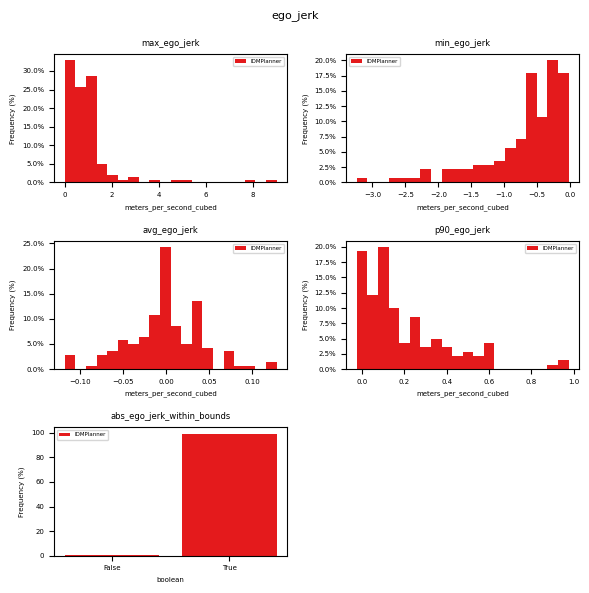

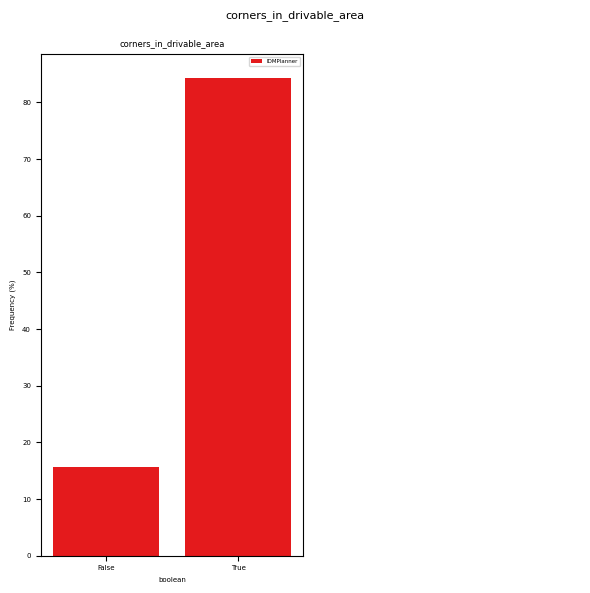

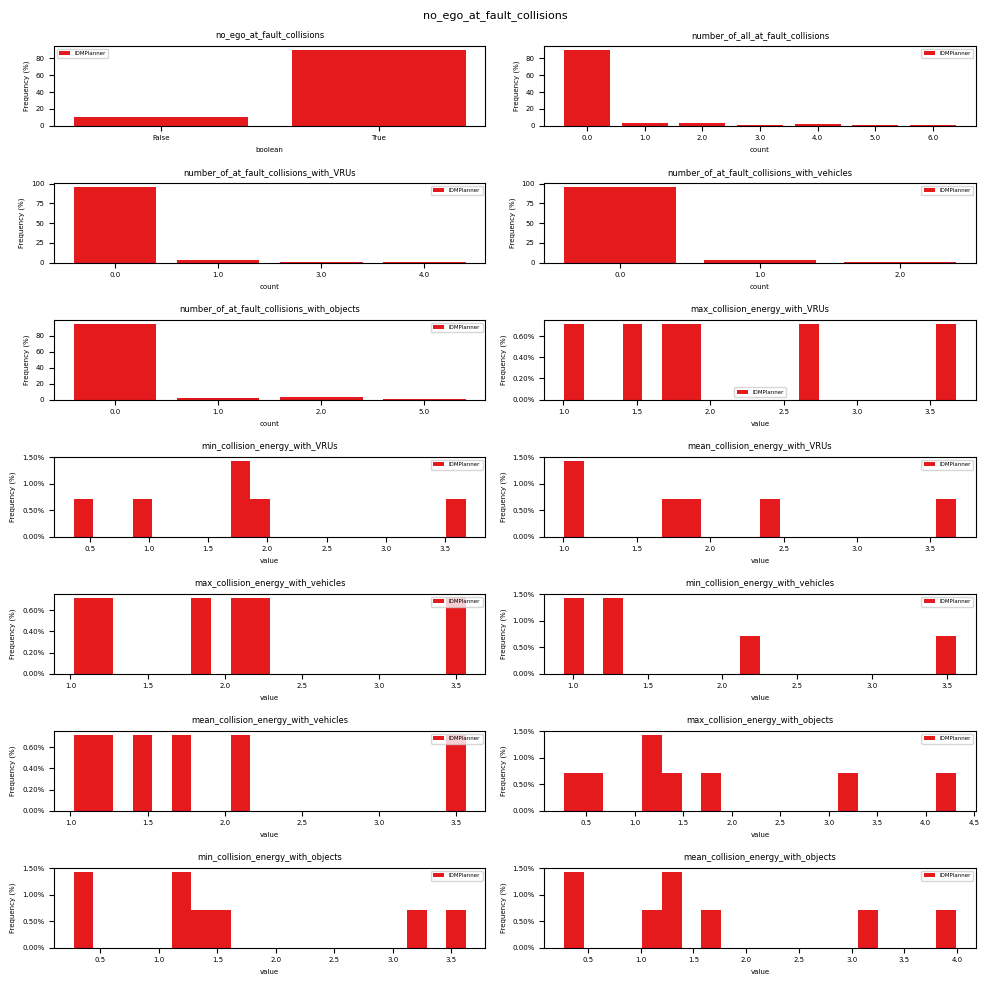

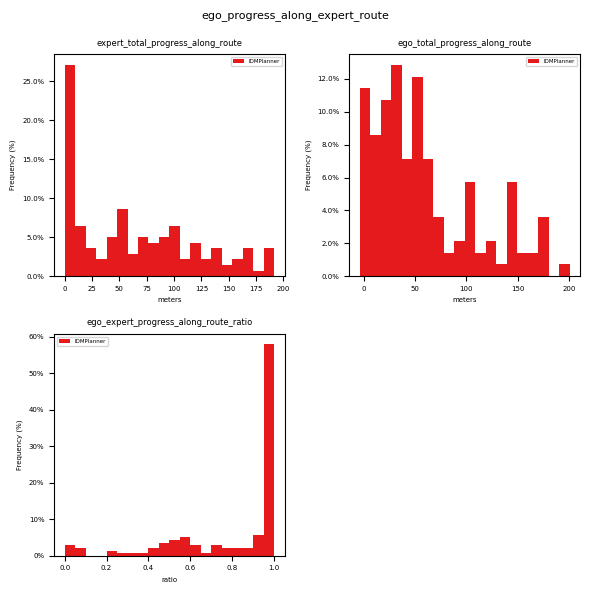

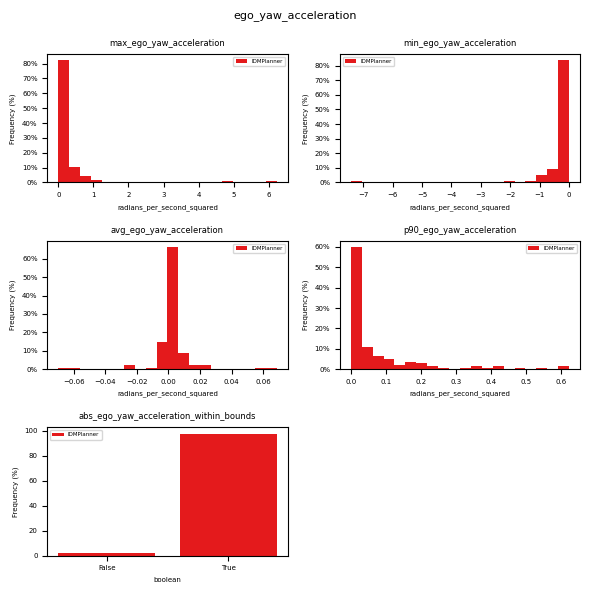

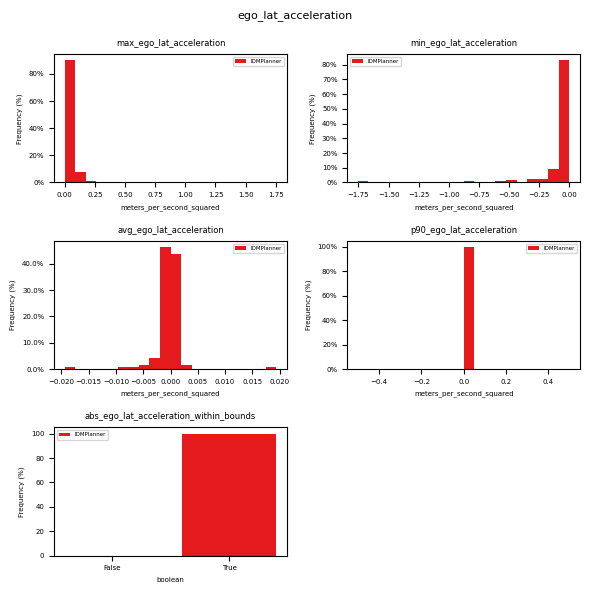

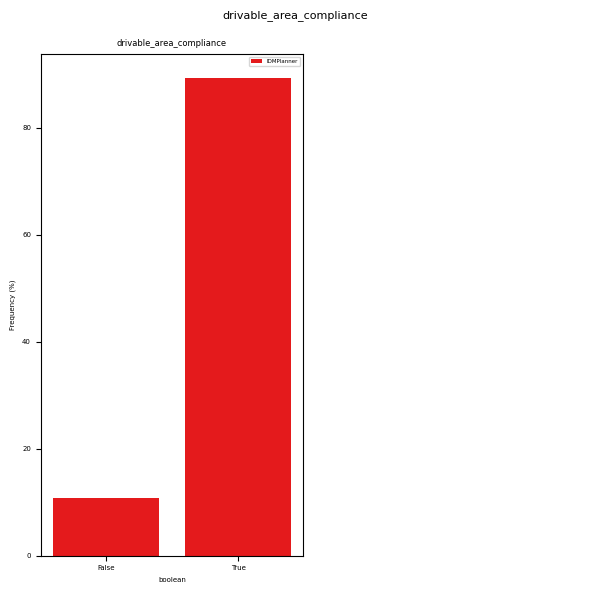

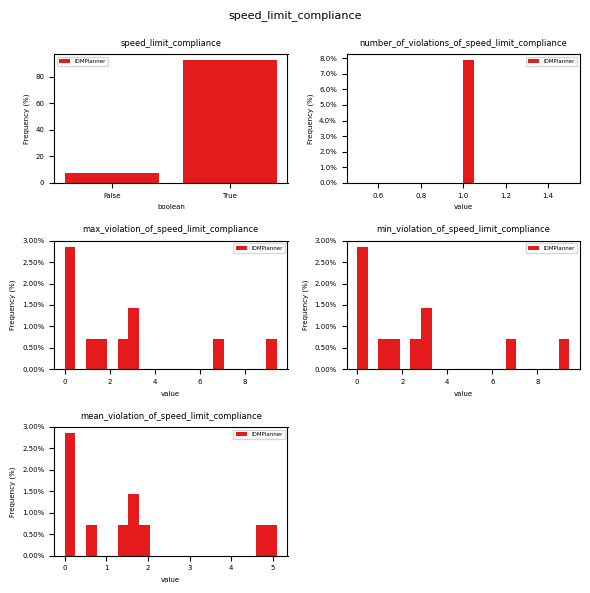

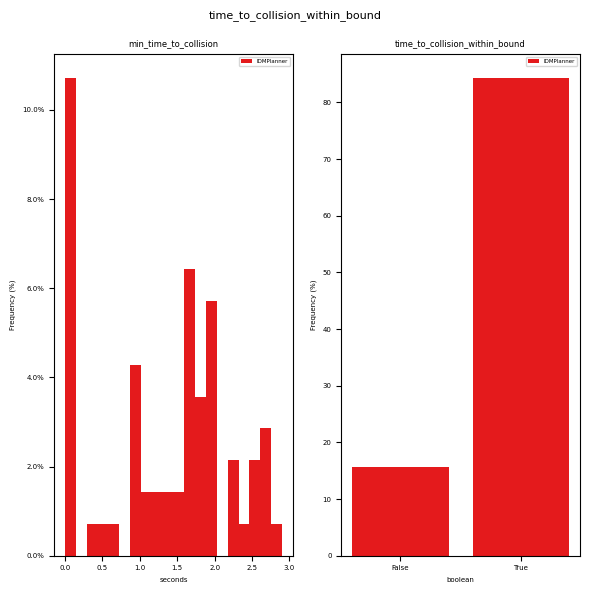

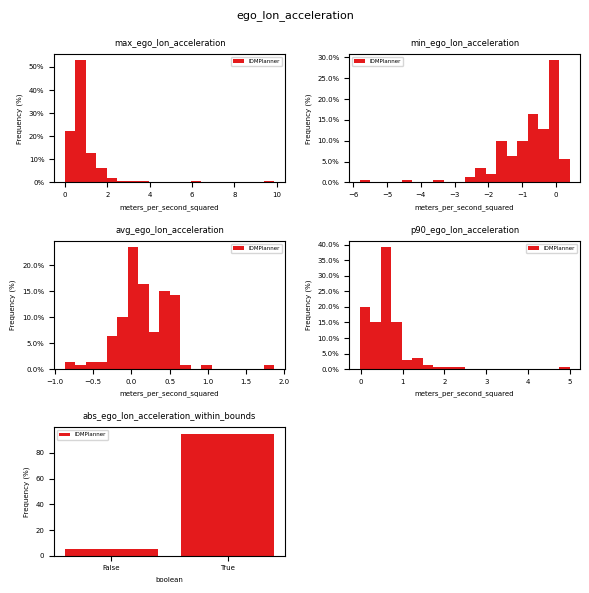

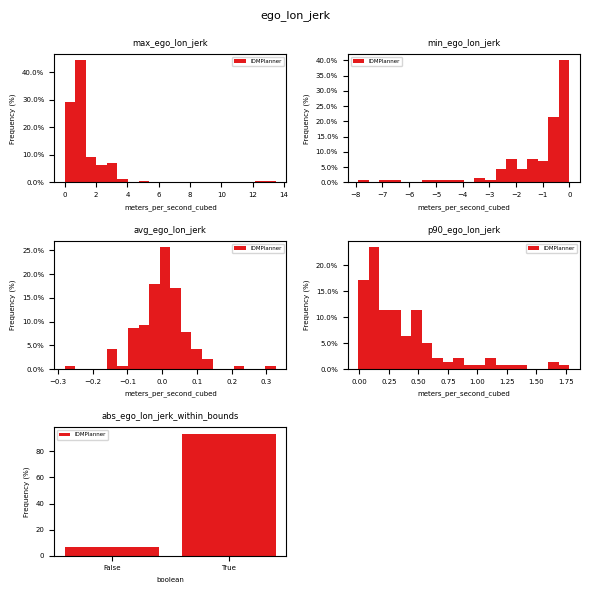

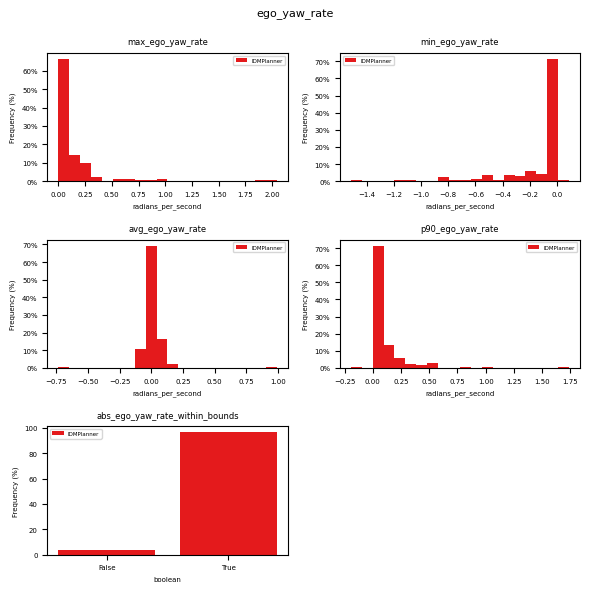

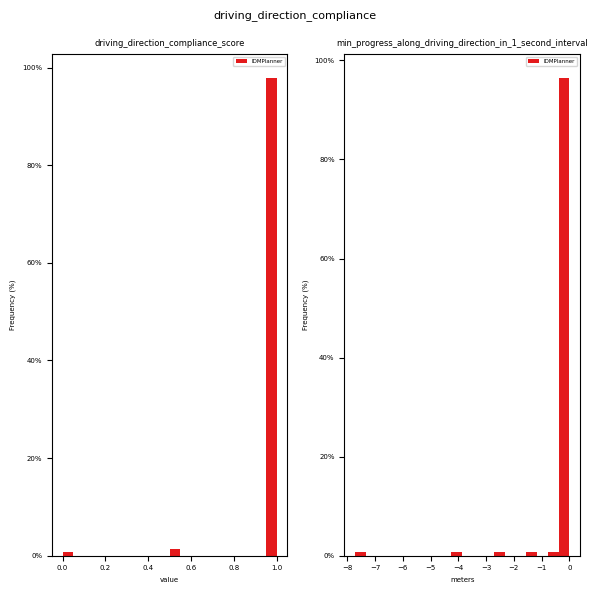

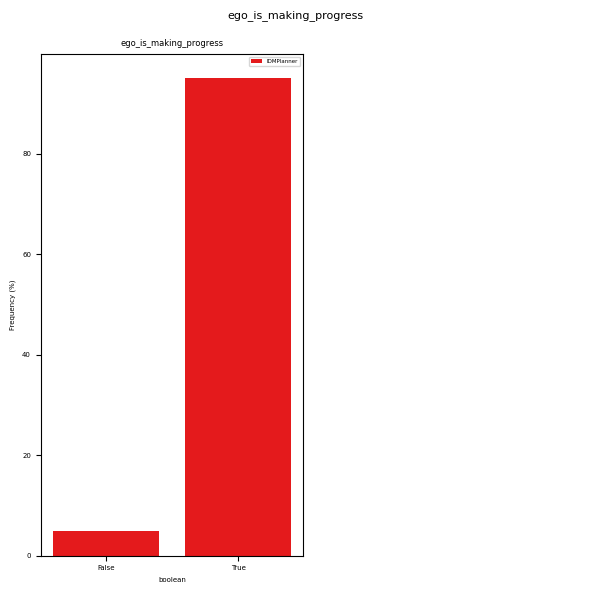

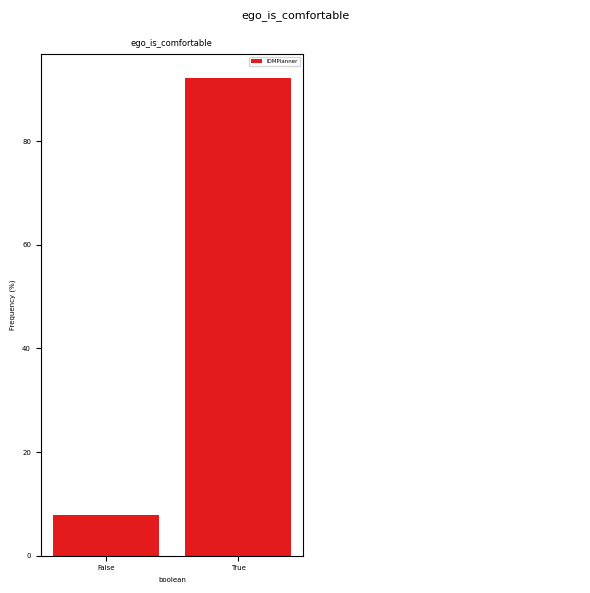

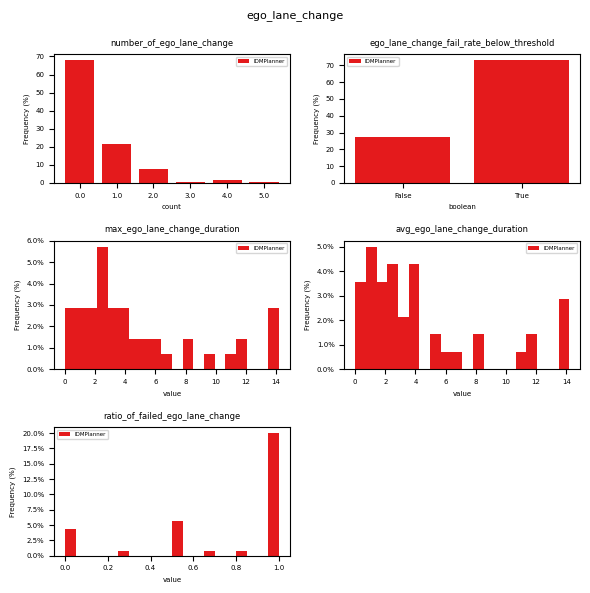

(raylet) [2023-03-26 19:56:26,517 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13378072576; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:56:36,524 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13378105344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:56:46,532 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13378105344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 19:56:56,539 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13378101248; capacity: 490577010688. Obj

(raylet) [2023-03-26 20:01:26,742 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13377744896; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:01:36,750 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13377740800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:01:46,757 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13377740800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:01:56,764 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13377740800; capacity: 490577010688. Obj

(raylet) [2023-03-26 20:06:26,962 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13377384448; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:06:36,968 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13377380352; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:06:46,975 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13377376256; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:06:56,982 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13377376256; capacity: 490577010688. Obj

(raylet) [2023-03-26 20:11:27,177 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13377040384; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:11:37,184 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13377040384; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:11:47,191 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13377040384; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:11:57,197 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13377032192; capacity: 490577010688. Obj

(raylet) [2023-03-26 20:16:27,388 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13376688128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:16:37,395 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13376688128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:16:47,402 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13376684032; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:16:57,409 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13376684032; capacity: 490577010688. Obj

(raylet) [2023-03-26 20:21:27,603 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13376344064; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:21:37,610 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13376331776; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:21:47,618 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13376331776; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:21:57,625 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13376327680; capacity: 490577010688. Obj

(raylet) [2023-03-26 20:26:27,815 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13376020480; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:26:37,822 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13376012288; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:26:47,830 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13376012288; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:26:57,837 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13376008192; capacity: 490577010688. Obj

(raylet) [2023-03-26 20:31:28,031 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13375647744; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:31:38,037 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13375647744; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:31:48,045 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13375643648; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:31:58,052 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13375639552; capacity: 490577010688. Obj

(raylet) [2023-03-26 20:36:28,249 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13375279104; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:36:38,256 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13375279104; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:36:48,263 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13375270912; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:36:58,271 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13375270912; capacity: 490577010688. Obj

(raylet) [2023-03-26 20:41:28,465 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13374947328; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:41:38,472 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13374939136; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:41:48,480 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13374939136; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:41:58,488 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13374939136; capacity: 490577010688. Obj

(raylet) [2023-03-26 20:46:28,680 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13374607360; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:46:38,688 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13374607360; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:46:48,695 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13374603264; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:46:58,702 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13374603264; capacity: 490577010688. Obj

(raylet) [2023-03-26 20:51:28,905 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13374259200; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:51:38,913 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13374259200; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:51:48,921 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13374259200; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:51:58,928 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13374255104; capacity: 490577010688. Obj

(raylet) [2023-03-26 20:56:29,149 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13373898752; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:56:39,156 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13373894656; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:56:49,163 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13373894656; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 20:56:59,170 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13373890560; capacity: 490577010688. Obj

(raylet) [2023-03-26 21:01:29,367 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13373566976; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:01:39,373 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13373566976; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:01:49,381 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13373558784; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:01:59,389 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13373558784; capacity: 490577010688. Obj

(raylet) [2023-03-26 21:06:29,624 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13373198336; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:06:39,632 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13373198336; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:06:49,640 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13373198336; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:06:59,648 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13373194240; capacity: 490577010688. Obj

(raylet) [2023-03-26 21:11:29,885 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372841984; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:11:39,892 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372837888; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:11:49,900 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372837888; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:11:59,908 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372837888; capacity: 490577010688. Obj

(raylet) [2023-03-26 21:16:30,113 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372534784; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:16:40,121 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372534784; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:16:50,129 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372526592; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:17:00,137 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372526592; capacity: 490577010688. Obj

(raylet) [2023-03-26 21:21:30,340 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372186624; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:21:40,348 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372186624; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:21:50,356 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372186624; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:22:00,364 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372182528; capacity: 490577010688. Obj

(raylet) [2023-03-26 21:26:30,564 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371809792; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:26:40,571 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371805696; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:26:50,578 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371805696; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:27:00,585 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371817984; capacity: 490577010688. Obj

(raylet) [2023-03-26 21:31:30,781 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371428864; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:31:40,789 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371428864; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:31:50,796 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371424768; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:32:00,803 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371437056; capacity: 490577010688. Obj

(raylet) [2023-03-26 21:36:31,002 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371072512; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:36:41,009 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371072512; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:36:51,016 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371080704; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:37:01,024 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371076608; capacity: 490577010688. Obj

(raylet) [2023-03-26 21:41:31,229 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13370728448; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:41:41,237 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13370724352; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:41:51,245 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13370724352; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:42:01,253 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13370724352; capacity: 490577010688. Obj

(raylet) [2023-03-26 21:46:31,459 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13370400768; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:46:41,467 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13370400768; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:46:51,475 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13370396672; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:47:01,482 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13370396672; capacity: 490577010688. Obj

(raylet) [2023-03-26 21:51:31,688 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13370040320; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:51:41,696 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13370040320; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:51:51,703 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13370036224; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:52:01,710 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13370032128; capacity: 490577010688. Obj

(raylet) [2023-03-26 21:56:31,918 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13369671680; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:56:41,926 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372157952; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:56:51,934 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372157952; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 21:57:01,942 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372157952; capacity: 490577010688. Obj

(raylet) [2023-03-26 22:01:32,146 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371813888; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:01:42,153 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371813888; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:01:52,161 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371809792; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:02:02,168 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371809792; capacity: 490577010688. Obj

(raylet) [2023-03-26 22:06:32,372 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13367496704; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:06:42,380 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372977152; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:06:52,387 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372977152; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:07:02,394 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372973056; capacity: 490577010688. Obj

(raylet) [2023-03-26 22:11:32,597 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372628992; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:11:42,604 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372624896; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:11:52,611 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372620800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:12:02,619 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372620800; capacity: 490577010688. Obj

(raylet) [2023-03-26 22:16:32,824 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372272640; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:16:42,832 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372272640; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:16:52,839 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372268544; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:17:02,847 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13372264448; capacity: 490577010688. Obj

(raylet) [2023-03-26 22:21:33,055 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371928576; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:21:43,062 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371924480; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:21:53,070 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371924480; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:22:03,078 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371932672; capacity: 490577010688. Obj

(raylet) [2023-03-26 22:26:33,275 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371584512; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:26:43,282 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371580416; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:26:53,289 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371580416; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:27:03,296 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371576320; capacity: 490577010688. Obj

(raylet) [2023-03-26 22:31:33,483 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371211776; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:31:43,490 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371211776; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:31:53,497 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371207680; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:32:03,504 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13371219968; capacity: 490577010688. Obj

(raylet) [2023-03-26 22:36:33,717 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13370884096; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:36:43,725 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13370880000; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:36:53,732 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13370880000; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:37:03,740 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13370888192; capacity: 490577010688. Obj

(raylet) [2023-03-26 22:41:33,945 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13370552320; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:41:43,952 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13370552320; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:41:53,959 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13370548224; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:42:03,968 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13370548224; capacity: 490577010688. Obj

(raylet) [2023-03-26 22:46:34,209 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13370195968; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:46:44,216 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13370195968; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:46:54,223 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13370191872; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:47:04,231 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13370191872; capacity: 490577010688. Obj

(raylet) [2023-03-26 22:51:34,438 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13369839616; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:51:44,445 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13369798656; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:51:54,453 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13369819136; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:52:04,461 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13369810944; capacity: 490577010688. Obj

(raylet) [2023-03-26 22:56:34,668 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13369507840; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:56:44,675 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13369503744; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:56:54,683 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13369499648; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 22:57:04,691 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13369491456; capacity: 490577010688. Obj

(raylet) [2023-03-26 23:01:34,898 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13369159680; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:01:44,905 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13369159680; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:01:54,912 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13369155584; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:02:04,920 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13369147392; capacity: 490577010688. Obj

(raylet) [2023-03-26 23:06:35,122 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13368856576; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:06:45,130 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13368852480; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:06:55,137 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13368852480; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:07:05,145 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13368848384; capacity: 490577010688. Obj

(raylet) [2023-03-26 23:11:35,350 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13368487936; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:11:45,357 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13368487936; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:11:55,365 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13368483840; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:12:05,372 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13368475648; capacity: 490577010688. Obj

(raylet) [2023-03-26 23:16:35,580 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13368135680; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:16:45,587 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13368135680; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:16:55,595 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13368135680; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:17:05,603 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13368127488; capacity: 490577010688. Obj

(raylet) [2023-03-26 23:21:35,803 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13367787520; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:21:45,810 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13367783424; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:21:55,818 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13367783424; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:22:05,825 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13367775232; capacity: 490577010688. Obj

(raylet) [2023-03-26 23:26:36,015 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13367443456; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:26:46,022 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13367443456; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:26:56,029 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13367435264; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:27:06,037 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13367439360; capacity: 490577010688. Obj

(raylet) [2023-03-26 23:31:36,237 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13367111680; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:31:46,245 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13367107584; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:31:56,252 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13367107584; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:32:06,260 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13367091200; capacity: 490577010688. Obj

(raylet) [2023-03-26 23:36:36,464 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13350178816; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:36:46,472 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13350174720; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:36:56,479 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13350174720; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:37:06,486 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13350146048; capacity: 490577010688. Obj

(raylet) [2023-03-26 23:41:36,679 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13349814272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:41:46,685 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13349814272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:41:56,692 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13349810176; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:42:06,699 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13349781504; capacity: 490577010688. Obj

(raylet) [2023-03-26 23:46:36,888 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13349478400; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:46:46,895 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13349478400; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:46:56,902 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13349478400; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:47:06,910 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13349453824; capacity: 490577010688. Obj

(raylet) [2023-03-26 23:51:37,109 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13349138432; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:51:47,116 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13349138432; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:51:57,123 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13349134336; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:52:07,131 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13349113856; capacity: 490577010688. Obj

(raylet) [2023-03-26 23:56:37,326 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13348765696; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:56:47,333 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13348765696; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:56:57,341 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13348761600; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 23:57:07,348 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13348724736; capacity: 490577010688. Obj

(raylet) [2023-03-27 00:01:37,528 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13352923136; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:01:47,534 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13352919040; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:01:57,540 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13352914944; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:02:07,546 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13352857600; capacity: 490577010688. Obj

(raylet) [2023-03-27 00:06:37,701 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13352607744; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:06:47,707 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13352603648; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:06:57,713 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13352599552; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:07:07,718 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13352534016; capacity: 490577010688. Obj

(raylet) [2023-03-27 00:11:37,867 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13352210432; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:11:47,873 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13352210432; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:11:57,879 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13352206336; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:12:07,886 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13352169472; capacity: 490577010688. Obj

(raylet) [2023-03-27 00:16:38,039 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13351886848; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:16:48,043 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13351886848; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:16:58,048 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13351886848; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:17:08,053 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13351821312; capacity: 490577010688. Obj

(raylet) [2023-03-27 00:21:38,214 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13351555072; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:21:48,221 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13351550976; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:21:58,229 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13351550976; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:22:08,237 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13351481344; capacity: 490577010688. Obj

(raylet) [2023-03-27 00:26:38,434 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13351190528; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:26:48,441 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13351190528; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:26:58,449 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13351186432; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:27:08,456 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13351141376; capacity: 490577010688. Obj

(raylet) [2023-03-27 00:31:38,646 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13350748160; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:31:48,653 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13350744064; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:31:58,661 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13350744064; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:32:08,667 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13350699008; capacity: 490577010688. Obj

(raylet) [2023-03-27 00:36:38,854 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13350412288; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:36:48,861 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13350412288; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:36:58,869 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13350408192; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:37:08,876 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13350334464; capacity: 490577010688. Obj

(raylet) [2023-03-27 00:41:39,071 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13350051840; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:41:49,079 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13350051840; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:41:59,087 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13350055936; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:42:09,094 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13349994496; capacity: 490577010688. Obj

(raylet) [2023-03-27 00:46:39,289 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13349699584; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:46:49,297 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13349707776; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:46:59,304 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13349707776; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:47:09,311 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13349670912; capacity: 490577010688. Obj

(raylet) [2023-03-27 00:51:39,516 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13349400576; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:51:49,524 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13349396480; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:51:59,532 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13349396480; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:52:09,540 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13349326848; capacity: 490577010688. Obj

(raylet) [2023-03-27 00:56:39,738 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13349040128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:56:49,745 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13349040128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:56:59,752 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13349040128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 00:57:09,758 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13348974592; capacity: 490577010688. Obj

(raylet) [2023-03-27 01:01:39,953 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13348659200; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:01:49,960 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13348655104; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:01:59,967 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13348655104; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:02:09,974 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13348610048; capacity: 490577010688. Obj

(raylet) [2023-03-27 01:06:40,171 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13348274176; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:06:50,178 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13348274176; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:07:00,186 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13348270080; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:07:10,193 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13348200448; capacity: 490577010688. Obj

(raylet) [2023-03-27 01:11:40,395 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13347934208; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:11:50,401 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13347934208; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:12:00,409 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13347926016; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:12:10,416 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13347840000; capacity: 490577010688. Obj

(raylet) [2023-03-27 01:16:40,617 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13347581952; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:16:50,624 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13347577856; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:17:00,632 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13347573760; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:17:10,640 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13347524608; capacity: 490577010688. Obj

(raylet) [2023-03-27 01:21:40,876 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13347254272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:21:50,884 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13347254272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:22:00,892 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13347250176; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:22:10,898 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13347205120; capacity: 490577010688. Obj

(raylet) [2023-03-27 01:26:41,100 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13346914304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:26:51,108 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13346914304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:27:01,115 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13346914304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:27:11,123 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13346832384; capacity: 490577010688. Obj

(raylet) [2023-03-27 01:31:41,318 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13346541568; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:31:51,326 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13346537472; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:32:01,333 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13346537472; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:32:11,340 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13346488320; capacity: 490577010688. Obj

(raylet) [2023-03-27 01:36:41,527 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13346181120; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:36:51,535 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13346181120; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:37:01,542 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13346177024; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:37:11,549 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13346140160; capacity: 490577010688. Obj

(raylet) [2023-03-27 01:41:41,739 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13345841152; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:41:51,746 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13345841152; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:42:01,753 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13345841152; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:42:11,760 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13345771520; capacity: 490577010688. Obj

(raylet) [2023-03-27 01:46:41,953 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13345492992; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:46:51,961 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13345484800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:47:01,968 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13345492992; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:47:11,976 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13345439744; capacity: 490577010688. Obj

(raylet) [2023-03-27 01:51:42,203 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13345128448; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:51:52,211 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13345128448; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:52:02,219 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13345124352; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:52:12,226 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13345087488; capacity: 490577010688. Obj

(raylet) [2023-03-27 01:56:42,424 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13344792576; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:56:52,432 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13344792576; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:57:02,439 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13344792576; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 01:57:12,446 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13344722944; capacity: 490577010688. Obj

(raylet) [2023-03-27 02:01:42,643 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13344456704; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:01:52,651 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13344452608; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:02:02,659 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13344452608; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:02:12,666 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13344370688; capacity: 490577010688. Obj

(raylet) [2023-03-27 02:06:42,867 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13344092160; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:06:52,875 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13344092160; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:07:02,882 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13344088064; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:07:12,889 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13344034816; capacity: 490577010688. Obj

(raylet) [2023-03-27 02:11:43,091 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13343752192; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:11:53,098 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13343752192; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:12:03,105 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13343752192; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:12:13,113 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13343703040; capacity: 490577010688. Obj

(raylet) [2023-03-27 02:16:43,310 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13343420416; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:16:53,354 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13343420416; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:17:03,361 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13343416320; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:17:13,368 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13343346688; capacity: 490577010688. Obj

(raylet) [2023-03-27 02:21:43,565 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13343039488; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:21:53,572 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13343031296; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:22:03,580 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13343027200; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:22:13,587 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13342978048; capacity: 490577010688. Obj

(raylet) [2023-03-27 02:26:43,786 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13342683136; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:26:53,792 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13342679040; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:27:03,799 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13342679040; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:27:13,807 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13342621696; capacity: 490577010688. Obj

(raylet) [2023-03-27 02:31:44,038 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13342355456; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:31:54,045 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13342351360; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:32:04,052 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13342351360; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:32:14,060 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13342289920; capacity: 490577010688. Obj

(raylet) [2023-03-27 02:36:44,265 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13342003200; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:36:54,272 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13342003200; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:37:04,280 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13341999104; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:37:14,287 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13341941760; capacity: 490577010688. Obj

(raylet) [2023-03-27 02:41:44,484 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13341634560; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:41:54,492 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13341634560; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:42:04,500 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13341646848; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:42:14,508 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13341605888; capacity: 490577010688. Obj

(raylet) [2023-03-27 02:46:44,731 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13341310976; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:46:54,739 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13341310976; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:47:04,746 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13341315072; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:47:14,754 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13341261824; capacity: 490577010688. Obj

(raylet) [2023-03-27 02:51:44,954 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13340954624; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:51:54,961 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13340954624; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:52:04,968 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13340946432; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:52:14,975 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13340893184; capacity: 490577010688. Obj

(raylet) [2023-03-27 02:56:45,170 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13340594176; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:56:55,177 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13340590080; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:57:05,185 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13340577792; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 02:57:15,192 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13340532736; capacity: 490577010688. Obj

(raylet) [2023-03-27 03:01:45,394 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13340266496; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:01:55,402 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13340262400; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:02:05,409 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13340254208; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:02:15,417 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13340217344; capacity: 490577010688. Obj

(raylet) [2023-03-27 03:06:45,618 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13339926528; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:06:55,624 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13339926528; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:07:05,632 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13339918336; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:07:15,640 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13339844608; capacity: 490577010688. Obj

(raylet) [2023-03-27 03:11:45,843 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13339529216; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:11:55,850 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13339525120; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:12:05,858 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13339516928; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:12:15,865 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13339471872; capacity: 490577010688. Obj

(raylet) [2023-03-27 03:16:46,065 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13339185152; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:16:56,072 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13339185152; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:17:06,080 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13339176960; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:17:16,087 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13339131904; capacity: 490577010688. Obj

(raylet) [2023-03-27 03:21:46,286 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13338861568; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:21:56,294 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13338861568; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:22:06,302 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13338857472; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:22:16,309 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13338800128; capacity: 490577010688. Obj

(raylet) [2023-03-27 03:26:46,510 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13338513408; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:26:56,517 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13338509312; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:27:06,524 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13338484736; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:27:16,532 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13338443776; capacity: 490577010688. Obj

(raylet) [2023-03-27 03:31:46,733 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13338169344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:31:56,741 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13338169344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:32:06,748 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13338140672; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:32:16,756 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13338120192; capacity: 490577010688. Obj

(raylet) [2023-03-27 03:36:46,962 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13337817088; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:36:56,969 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13337812992; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:37:06,975 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13337804800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:37:16,983 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13337763840; capacity: 490577010688. Obj

(raylet) [2023-03-27 03:41:47,172 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13337456640; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:41:57,178 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13337452544; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:42:07,185 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13337423872; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:42:17,192 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13337387008; capacity: 490577010688. Obj

(raylet) [2023-03-27 03:46:47,386 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13337104384; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:46:57,393 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13337104384; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:47:07,400 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13337075712; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:47:17,408 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13337051136; capacity: 490577010688. Obj

(raylet) [2023-03-27 03:51:47,594 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13336776704; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:51:57,602 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13336776704; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:52:07,609 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13336752128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:52:17,616 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13336723456; capacity: 490577010688. Obj

(raylet) [2023-03-27 03:56:47,808 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13336440832; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:56:57,816 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13336436736; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:57:07,824 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13336412160; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 03:57:17,831 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13336354816; capacity: 490577010688. Obj

(raylet) [2023-03-27 04:01:48,027 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13336088576; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:01:58,034 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13336088576; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:02:08,041 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13336064000; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:02:18,048 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13336035328; capacity: 490577010688. Obj

(raylet) [2023-03-27 04:06:48,244 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13333643264; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:06:58,252 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13333651456; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:07:08,259 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13333622784; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:07:18,266 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13333594112; capacity: 490577010688. Obj

(raylet) [2023-03-27 04:11:48,466 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13333270528; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:11:58,474 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13333266432; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:12:08,481 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13333241856; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:12:18,488 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13333204992; capacity: 490577010688. Obj

(raylet) [2023-03-27 04:16:48,690 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13332930560; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:16:58,698 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13332930560; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:17:08,705 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13332901888; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:17:18,712 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13332860928; capacity: 490577010688. Obj

(raylet) [2023-03-27 04:21:48,913 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13332594688; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:21:58,921 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13332594688; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:22:08,928 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13332537344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:22:18,936 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13332447232; capacity: 490577010688. Obj

(raylet) [2023-03-27 04:26:49,132 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13322383360; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:26:59,139 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13322379264; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:27:09,147 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13322317824; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:27:19,154 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13322313728; capacity: 490577010688. Obj

(raylet) [2023-03-27 04:31:49,353 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13322002432; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:31:59,361 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13322014720; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:32:09,369 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13321953280; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:32:19,377 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13321949184; capacity: 490577010688. Obj

(raylet) [2023-03-27 04:36:49,582 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13321646080; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:36:59,590 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13321650176; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:37:09,597 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13321609216; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:37:19,604 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13321601024; capacity: 490577010688. Obj

(raylet) [2023-03-27 04:41:49,802 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13321314304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:41:59,810 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13321310208; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:42:09,817 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13321261056; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:42:19,824 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13321256960; capacity: 490577010688. Obj

(raylet) [2023-03-27 04:46:50,023 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13320974336; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:47:00,030 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13320974336; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:47:10,037 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13320912896; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:47:20,044 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13320908800; capacity: 490577010688. Obj

(raylet) [2023-03-27 04:51:50,234 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13320642560; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:52:00,241 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13320642560; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:52:10,248 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13320585216; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:52:20,255 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13320581120; capacity: 490577010688. Obj

(raylet) [2023-03-27 04:56:50,447 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13320294400; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:57:00,455 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13320290304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:57:10,462 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13320241152; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 04:57:20,469 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13320237056; capacity: 490577010688. Obj

(raylet) [2023-03-27 05:01:50,662 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13319925760; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:02:00,669 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13319925760; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:02:10,676 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13319868416; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:02:20,682 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13319864320; capacity: 490577010688. Obj

(raylet) [2023-03-27 05:06:50,874 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13319581696; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:07:00,881 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13319577600; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:07:10,888 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13319512064; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:07:20,896 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13319503872; capacity: 490577010688. Obj

(raylet) [2023-03-27 05:11:51,092 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13319229440; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:12:01,100 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13319225344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:12:11,108 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13319168000; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:12:21,115 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13319155712; capacity: 490577010688. Obj

(raylet) [2023-03-27 05:16:51,313 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13318881280; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:17:01,321 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13318881280; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:17:11,328 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13318832128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:17:21,335 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13318823936; capacity: 490577010688. Obj

(raylet) [2023-03-27 05:21:51,570 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13318561792; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:22:01,577 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13318557696; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:22:11,584 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13318496256; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:22:21,591 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13318496256; capacity: 490577010688. Obj

(raylet) [2023-03-27 05:26:51,798 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13318189056; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:27:01,806 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13318201344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:27:11,813 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13318152192; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:27:21,821 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13318148096; capacity: 490577010688. Obj

(raylet) [2023-03-27 05:31:52,021 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13317824512; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:32:02,027 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13317836800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:32:12,032 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13317787648; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:32:22,039 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13317783552; capacity: 490577010688. Obj

(raylet) [2023-03-27 05:36:52,240 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13317476352; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:37:02,247 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13317484544; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:37:12,254 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13317423104; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:37:22,261 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13317419008; capacity: 490577010688. Obj

(raylet) [2023-03-27 05:41:52,458 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13317136384; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:42:02,466 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13317124096; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:42:12,473 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13317058560; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:42:22,480 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13317058560; capacity: 490577010688. Obj

(raylet) [2023-03-27 05:46:52,684 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13316784128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:47:02,692 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13316780032; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:47:12,699 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13316734976; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:47:22,707 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13316739072; capacity: 490577010688. Obj

(raylet) [2023-03-27 05:51:52,912 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13316435968; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:52:02,919 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13316431872; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:52:12,926 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13316374528; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:52:22,934 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13316374528; capacity: 490577010688. Obj

(raylet) [2023-03-27 05:56:53,135 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13316075520; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:57:03,143 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13316063232; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:57:13,150 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13316001792; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 05:57:23,157 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13315997696; capacity: 490577010688. Obj

(raylet) [2023-03-27 06:01:53,357 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13315743744; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:02:03,364 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13315739648; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:02:13,371 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13315690496; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:02:23,378 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13315686400; capacity: 490577010688. Obj

(raylet) [2023-03-27 06:06:53,576 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13318979584; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:07:03,582 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13421400064; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:07:13,589 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13421342720; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:07:23,596 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13421338624; capacity: 490577010688. Obj

(raylet) [2023-03-27 06:11:53,790 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13421072384; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:12:03,797 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13421072384; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:12:13,805 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13421006848; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:12:23,812 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13421006848; capacity: 490577010688. Obj

(raylet) [2023-03-27 06:16:54,028 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13420724224; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:17:04,036 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13420720128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:17:14,043 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13420679168; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:17:24,051 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13420670976; capacity: 490577010688. Obj

(raylet) [2023-03-27 06:21:54,248 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13420351488; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:22:04,255 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13420359680; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:22:14,262 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13420306432; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:22:24,270 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13420306432; capacity: 490577010688. Obj

(raylet) [2023-03-27 06:26:54,463 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13420003328; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:27:04,470 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13420003328; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:27:14,477 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13419921408; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:27:24,485 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13419941888; capacity: 490577010688. Obj

(raylet) [2023-03-27 06:31:54,678 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13419667456; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:32:04,685 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13419667456; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:32:14,692 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13419614208; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:32:24,699 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13419610112; capacity: 490577010688. Obj

(raylet) [2023-03-27 06:36:54,895 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13419323392; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:37:04,902 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13419311104; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:37:14,910 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13419241472; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:37:24,917 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13419241472; capacity: 490577010688. Obj

(raylet) [2023-03-27 06:41:55,111 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13418983424; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:42:05,119 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13418975232; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:42:15,126 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13418917888; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:42:25,134 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13418917888; capacity: 490577010688. Obj

(raylet) [2023-03-27 06:46:55,334 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13418643456; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:47:05,342 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13418635264; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:47:15,350 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13418577920; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:47:25,357 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13418573824; capacity: 490577010688. Obj

(raylet) [2023-03-27 06:51:55,565 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13418278912; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:52:05,572 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13418270720; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:52:15,580 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13418221568; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:52:25,587 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13418217472; capacity: 490577010688. Obj

(raylet) [2023-03-27 06:56:55,785 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13311897600; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:57:05,791 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13311889408; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:57:15,798 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13311832064; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 06:57:25,806 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13311832064; capacity: 490577010688. Obj

(raylet) [2023-03-27 07:01:56,010 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13311569920; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:02:06,017 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13311561728; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:02:16,025 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13311512576; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:02:26,033 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13311508480; capacity: 490577010688. Obj

(raylet) [2023-03-27 07:06:56,239 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13311148032; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:07:06,247 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13311131648; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:07:16,254 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13311086592; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:07:26,262 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13311086592; capacity: 490577010688. Obj

(raylet) [2023-03-27 07:11:56,472 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13310746624; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:12:06,480 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13310738432; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:12:16,486 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13310693376; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:12:26,493 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13310693376; capacity: 490577010688. Obj

(raylet) [2023-03-27 07:16:56,694 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13310398464; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:17:06,702 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13310402560; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:17:16,710 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13310349312; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:17:26,718 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13310349312; capacity: 490577010688. Obj

(raylet) [2023-03-27 07:21:56,919 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13310074880; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:22:06,927 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13310050304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:22:16,934 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13310009344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:22:26,941 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13309997056; capacity: 490577010688. Obj

(raylet) [2023-03-27 07:26:57,141 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13309722624; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:27:07,149 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13309702144; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:27:17,156 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13309665280; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:27:27,162 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13309661184; capacity: 490577010688. Obj

(raylet) [2023-03-27 07:31:57,367 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13309403136; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:32:07,374 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13309378560; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:32:17,381 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13309341696; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:32:27,389 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13309321216; capacity: 490577010688. Obj

(raylet) [2023-03-27 07:36:57,594 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13309050880; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:37:07,603 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13309014016; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:37:17,611 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13308973056; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:37:27,618 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13308973056; capacity: 490577010688. Obj

(raylet) [2023-03-27 07:41:57,820 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13308669952; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:42:07,827 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13308645376; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:42:17,835 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13308612608; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:42:27,843 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13308612608; capacity: 490577010688. Obj

(raylet) [2023-03-27 07:46:58,038 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13308325888; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:47:08,046 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13308297216; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:47:18,053 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13308264448; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:47:28,060 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13308264448; capacity: 490577010688. Obj

(raylet) [2023-03-27 07:51:58,256 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13307961344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:52:08,262 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13307932672; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:52:18,270 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13307904000; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:52:28,277 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13307879424; capacity: 490577010688. Obj

(raylet) [2023-03-27 07:56:58,459 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13307240448; capacity: 490577010688. Object creation will fail if spilling is required.


In [5]:
from nuplan.planning.script.run_simulation import main as main_simulation

# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg)

# Simple simulation folder for visualization in nuBoard
simple_simulation_folder = cfg.output_dir

## Launch simulation (command line - alternative)

A simulation experiment can be launched alternatively with:
```
$ python nuplan/planning/script/run_simulation.py \
    +simulation=open_loop_boxes \
    planner=simple_planner \
    scenario_builder=nuplan_mini \
    scenario_filter=all_scenarios \
    scenario_filter.scenario_types="[near_multiple_vehicles, on_pickup_dropoff, starting_unprotected_cross_turn, high_magnitude_jerk]" \
    scenario_filter.num_scenarios_per_type=10 \
```

## Simulate a trained ML planner for comparison

Using the same simulation settings as before, we can simulate a pretrained ML planner and compare the two.

In this example you can take the model you trained earlier.

In [ ]:
from nuplan.planning.script.run_simulation import main as main_simulation
# Location of path with all simulation configs
CONFIG_PATH = '../nuplan/planning/script/config/simulation'
CONFIG_NAME = 'default_simulation'

# Get the checkpoint of the trained model
last_experiment = sorted(os.listdir(LOG_DIR))[-1]
train_experiment_dir = sorted(Path(LOG_DIR).iterdir())[-1]
checkpoint = sorted((train_experiment_dir / 'checkpoints').iterdir())[-1]

MODEL_PATH = str(checkpoint).replace("=", "\=")

# Name of the experiment
EXPERIMENT = 'simulation_raster_experiment'

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    f'experiment_name={EXPERIMENT}',
    f'group={SAVE_DIR}',
    'planner=ml_planner',
    'model=raster_model',
    'planner.ml_planner.model_config=${model}',  # hydra notation to select model config
    f'planner.ml_planner.checkpoint_path={MODEL_PATH}',  # this path can be replaced by the checkpoint of the model trained in the previous section
    f'+simulation={CHALLENGE}',
    *DATASET_PARAMS,
])

# Run the simulation loop
main_simulation(cfg)

# ML_planner simulation folder for visualization in nuBoard (next section)
ml_planner_simulation_folder = cfg.output_dir

Global seed set to 0


2023-03-26 16:16:13,274 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:20}  Building MultiMainCallback...
2023-03-26 16:16:13,610 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:35}  Building MultiMainCallback: 4...DONE!
2023-03-26 16:16:13,782 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-03-26 16:16:13,783 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:129}  Ray is running, we will shut it down before starting again!
2023-03-26 16:16:16,399 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:75}  Starting ray local!


2023-03-26 16:16:18,367	INFO worker.py:1553 -- Started a local Ray instance.


2023-03-26 16:16:19,330 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2023-03-26 16:16:19,330 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 12
Number of GPUs per node: 1
Number of threads across all nodes: 12
2023-03-26 16:16:19,330 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2023-03-26 16:16:19,331 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:29}  Building experiment folders...
2023-03-26 16:16:19,331 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  

	Folder where all results are stored: /hdd/vladislav/nuplan-results/simulation_raster_experiment/closed_loop_nonreactive_agents/2023.03.26.16.16.13

2023-03-26 16:16:19,331 INFO {/hdd/vladislav/nuplan-devkit/nuplan/plannin

Ray objects: 100%|███████████████████████████████████████████████████████| 12/12 [00:09<00:00,  1.22it/s]


2023-03-26 16:16:29,217 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:55}  Extracting scenarios 140...DONE!
2023-03-26 16:16:29,218 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:59}  Building metric engines...
2023-03-26 16:16:29,862 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:61}  Building metric engines...DONE
2023-03-26 16:16:29,862 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:65}  Building simulations from 140 scenarios...
2023-03-26 16:16:29,865 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-03-26 16:16:30,096 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/res

2023-03-26 16:16:36,187 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-03-26 16:16:36,404 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-03-26 16:16:36,421 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:275}  Converted input conv conv1 pretrained weights from 3 to 4 channel(s)
2023-03-26 16:16:36,438 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2023-03-26 16:16:36,839 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-03-26 16:16:37,051 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-package

(raylet) [2023-03-26 16:16:38,295 E 122903 122922] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_16-16-16_425421_120779 is over 95% full, available space: 13279858688; capacity: 490577010688. Object creation will fail if spilling is required.


2023-03-26 16:16:38,324 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-03-26 16:16:38,346 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:275}  Converted input conv conv1 pretrained weights from 3 to 4 channel(s)
2023-03-26 16:16:38,365 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2023-03-26 16:16:38,571 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-03-26 16:16:38,799 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb

2023-03-26 16:16:44,381 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-03-26 16:16:44,595 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-03-26 16:16:44,611 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:275}  Converted input conv conv1 pretrained weights from 3 to 4 channel(s)
2023-03-26 16:16:44,633 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2023-03-26 16:16:45,030 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-03-26 16:16:45,243 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-package

(raylet) [2023-03-26 16:16:48,298 E 122903 122922] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_16-16-16_425421_120779 is over 95% full, available space: 13279813632; capacity: 490577010688. Object creation will fail if spilling is required.


2023-03-26 16:16:48,433 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-03-26 16:16:48,657 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-03-26 16:16:48,679 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:275}  Converted input conv conv1 pretrained weights from 3 to 4 channel(s)
2023-03-26 16:16:48,697 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2023-03-26 16:16:49,208 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-03-26 16:16:49,423 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-package

2023-03-26 16:16:55,434 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-03-26 16:16:55,650 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-03-26 16:16:55,666 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:275}  Converted input conv conv1 pretrained weights from 3 to 4 channel(s)
2023-03-26 16:16:55,684 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2023-03-26 16:16:56,081 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-03-26 16:16:56,295 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-package

(raylet) [2023-03-26 16:16:58,302 E 122903 122922] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_16-16-16_425421_120779 is over 95% full, available space: 13279772672; capacity: 490577010688. Object creation will fail if spilling is required.


2023-03-26 16:16:58,450 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-03-26 16:16:58,676 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-03-26 16:16:58,702 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:275}  Converted input conv conv1 pretrained weights from 3 to 4 channel(s)
2023-03-26 16:16:58,720 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2023-03-26 16:16:58,916 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-03-26 16:16:59,127 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-package

2023-03-26 16:17:05,249 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-03-26 16:17:05,473 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-03-26 16:17:05,502 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:275}  Converted input conv conv1 pretrained weights from 3 to 4 channel(s)
2023-03-26 16:17:05,523 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2023-03-26 16:17:05,911 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-03-26 16:17:06,123 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-package

(raylet) [2023-03-26 16:17:08,307 E 122903 122922] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_16-16-16_425421_120779 is over 95% full, available space: 13279645696; capacity: 490577010688. Object creation will fail if spilling is required.


2023-03-26 16:17:08,525 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-03-26 16:17:08,546 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:275}  Converted input conv conv1 pretrained weights from 3 to 4 channel(s)
2023-03-26 16:17:08,568 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2023-03-26 16:17:08,788 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-03-26 16:17:09,014 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb

2023-03-26 16:17:18,100 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-03-26 16:17:18,328 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-03-26 16:17:18,370 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:275}  Converted input conv conv1 pretrained weights from 3 to 4 channel(s)
2023-03-26 16:17:18,389 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!


(raylet) [2023-03-26 16:17:18,302 E 122903 122903] (raylet) node_manager.cc:3040: 12 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 482891dafcdc742f310e693a9c461c22223b28e25e2e61610e112793, IP: 192.168.0.128) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.0.128`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(raylet) [2023-03-26 16:17:18,312 E 122903 122922] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03

2023-03-26 16:17:20,780 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-03-26 16:17:21,007 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-03-26 16:17:21,087 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:275}  Converted input conv conv1 pretrained weights from 3 to 4 channel(s)
2023-03-26 16:17:21,108 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2023-03-26 16:17:23,759 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-03-26 16:17:24,027 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-package

(raylet) [2023-03-26 16:17:28,317 E 122903 122922] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_16-16-16_425421_120779 is over 95% full, available space: 13279498240; capacity: 490577010688. Object creation will fail if spilling is required.


2023-03-26 16:17:30,112 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-03-26 16:17:30,463 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-03-26 16:17:30,700 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:275}  Converted input conv conv1 pretrained weights from 3 to 4 channel(s)
2023-03-26 16:17:30,740 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!


(raylet) [2023-03-26 16:17:38,402 E 122903 122922] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_16-16-16_425421_120779 is over 95% full, available space: 13279485952; capacity: 490577010688. Object creation will fail if spilling is required.


# Visualizing metrics and scenarios <a name="dashboard"></a>

## nuBoard summary

Having trained and simulated planners across various scenarios and driving behaviors, it's time to evaluate them:
* quantitatively, through common and scenario dependent metrics
* qualitatively, through visualization of scenario progression

### nuBoard tabs
To achieve that, nuBoard has 3 core evaluation tabs:
1. Overview - Scalar metrics summary of common and scenario metrics across the following categories:
    * Ego dynamics
    * Traffic violations
    * Expert imitation
    * Planning & navigation
    * Scenario performance
2. Histograms - Histograms over metric statistics for more a granular peek inside each metric focusing on:
    * Metric statistics (e.g. min, max, p90)
3. Scenarios - Low-level scenario visualizations:
    * Time-series progression of a specific metric across a scenario
    * Top-down visualization of the scenario across time for comparing predicted vs. expert trajectories

In addition, there is a main configuration tab for selecting different simulation files for comparing planners/experiments.

<br />

**NOTE**: nuBoard is under heavy developement, overall functionality and aesthetics do not represent the final product!

## Prepare the nuBoard config

In [6]:
# Location of path with all nuBoard configs
CONFIG_PATH = '../nuplan/planning/script/config/nuboard'
CONFIG_NAME = 'default_nuboard'

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    'scenario_builder=nuplan_mini',  # set the database (same as simulation) used to fetch data for visualization
    f'simulation_path={simple_simulation_folder}',  # nuboard file path(s), if left empty the user can open the file inside nuBoard #, ml_planner_simulation_folder
])

## Launch nuBoard (open in new tab - recommended)

In [8]:
simple_simulation_folder

'/hdd/vladislav/nuplan-results/IDM_experiment_closed_loop_reactive/closed_loop_reactive_agents/2023.03.26.19.07.03'

(raylet) [2023-03-27 08:01:48,664 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13292670976; capacity: 490577010688. Object creation will fail if spilling is required.


2023-03-27 08:01:57,424 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.0159 seconds.


(raylet) [2023-03-27 08:01:58,671 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13292642304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:02:08,678 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13292527616; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:02:18,684 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13292490752; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:02:28,691 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13292466176; capacity: 490577010688. Obj

2023-03-27 08:03:39,613 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 6.0716 seconds.


(raylet) [2023-03-27 08:03:48,746 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13292183552; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:03:58,752 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13292146688; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:04:08,759 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13292101632; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:04:18,766 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13292064768; capacity: 490577010688. Obj

2023-03-27 08:05:38,119 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:394}  Message: unknown error: cannot find Chrome binary
Stacktrace:
#0 0x55e987e3f243 <unknown>
#1 0x55e987c037a6 <unknown>
#2 0x55e987c2a94a <unknown>
#3 0x55e987c2849b <unknown>
#4 0x55e987c6a2a7 <unknown>
#5 0x55e987c698cf <unknown>
#6 0x55e987c60e53 <unknown>
#7 0x55e987c339ea <unknown>
#8 0x55e987c34b2e <unknown>
#9 0x55e987e93d5e <unknown>
#10 0x55e987e97a80 <unknown>
#11 0x55e987e798b0 <unknown>
#12 0x55e987e98b63 <unknown>
#13 0x55e987e6af75 <unknown>
#14 0x55e987ebb998 <unknown>
#15 0x55e987ebbb27 <unknown>
#16 0x55e987ed6c23 <unknown>
#17 0x7f6831090609 start_thread



(raylet) [2023-03-27 08:05:38,823 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13277814784; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:05:48,830 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13277790208; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:05:58,837 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13277761536; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:06:08,845 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13277712384; capacity: 490577010688. Obj

2023-03-27 08:06:10,434 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:394}  Message: unknown error: cannot find Chrome binary
Stacktrace:
#0 0x56314c8b4243 <unknown>
#1 0x56314c6787a6 <unknown>
#2 0x56314c69f94a <unknown>
#3 0x56314c69d49b <unknown>
#4 0x56314c6df2a7 <unknown>
#5 0x56314c6de8cf <unknown>
#6 0x56314c6d5e53 <unknown>
#7 0x56314c6a89ea <unknown>
#8 0x56314c6a9b2e <unknown>
#9 0x56314c908d5e <unknown>
#10 0x56314c90ca80 <unknown>
#11 0x56314c8ee8b0 <unknown>
#12 0x56314c90db63 <unknown>
#13 0x56314c8dff75 <unknown>
#14 0x56314c930998 <unknown>
#15 0x56314c930b27 <unknown>
#16 0x56314c94bc23 <unknown>
#17 0x7fcffdb71609 start_thread

2023-03-27 08:06:16,461 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:394}  Message: unknown error: cannot find Chrome binary
Stacktrace:
#0 0x55ae5789e243 <unknown>
#1 0x55ae576627a6 <unknown>
#2 0x55ae5768994a <unknown>
#3 0x55ae5768749b <unknown>
#4 0x55ae576c92a

(raylet) [2023-03-27 08:06:18,851 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13277642752; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:06:28,858 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13277605888; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:06:38,865 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13277560832; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:06:48,872 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13277511680; capacity: 490577010688. Obj

2023-03-27 08:07:23,808 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.1266 seconds.


(raylet) [2023-03-27 08:07:28,898 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13277233152; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:07:38,906 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13277196288; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:07:48,913 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13277171712; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:07:58,920 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13277134848; capacity: 490577010688. Obj

2023-03-27 08:09:32,287 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.0146 seconds.
2023-03-27 08:09:34,825 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.0149 seconds.


(raylet) [2023-03-27 08:09:38,989 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13276659712; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:09:48,995 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13276635136; capacity: 490577010688. Object creation will fail if spilling is required.


2023-03-27 08:09:54,406 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.0632 seconds.
2023-03-27 08:09:57,329 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.0595 seconds.


(raylet) [2023-03-27 08:09:59,000 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13276569600; capacity: 490577010688. Object creation will fail if spilling is required.


2023-03-27 08:10:08,217 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.1583 seconds.


(raylet) [2023-03-27 08:10:09,006 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13276557312; capacity: 490577010688. Object creation will fail if spilling is required.


2023-03-27 08:10:11,319 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.1478 seconds.


(raylet) [2023-03-27 08:10:19,013 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13276504064; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:10:29,020 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13276479488; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:10:39,028 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13276475392; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:10:49,035 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13276438528; capacity: 490577010688. Obj

(raylet) [2023-03-27 08:15:19,238 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13275938816; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:15:29,245 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13275926528; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:15:39,253 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13275922432; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:15:49,260 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13275914240; capacity: 490577010688. Obj

(raylet) [2023-03-27 08:20:19,458 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13275561984; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:20:29,466 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13275545600; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:20:39,472 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13275545600; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:20:49,480 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13275545600; capacity: 490577010688. Obj

(raylet) [2023-03-27 08:25:19,711 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13275201536; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:25:29,718 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13275201536; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:25:39,725 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13275201536; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:25:49,732 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13275197440; capacity: 490577010688. Obj

(raylet) [2023-03-27 08:30:19,926 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13274804224; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:30:29,934 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13274800128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:30:39,942 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13274800128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:30:49,949 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13274796032; capacity: 490577010688. Obj

(raylet) [2023-03-27 08:35:20,138 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13274435584; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:35:30,145 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13274435584; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:35:40,153 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13274431488; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:35:50,160 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13274431488; capacity: 490577010688. Obj

(raylet) [2023-03-27 08:40:20,353 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13274828800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:40:30,360 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13274816512; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:40:40,367 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13274812416; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:40:50,374 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13274812416; capacity: 490577010688. Obj

(raylet) [2023-03-27 08:45:20,564 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13274484736; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:45:30,571 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13274476544; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:45:40,579 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13274476544; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:45:50,585 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13274472448; capacity: 490577010688. Obj

(raylet) [2023-03-27 08:50:20,776 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13274140672; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:50:30,783 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13274140672; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:50:40,791 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13274132480; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:50:50,797 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13274128384; capacity: 490577010688. Obj

(raylet) [2023-03-27 08:55:20,995 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13273788416; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:55:31,003 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13273788416; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:55:41,010 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13273788416; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:55:51,017 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13273784320; capacity: 490577010688. Obj

(raylet) [2023-03-27 09:00:21,208 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13273403392; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:00:31,215 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13273399296; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:00:41,222 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13273399296; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:00:51,230 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13273399296; capacity: 490577010688. Obj

(raylet) [2023-03-27 09:05:21,424 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13273047040; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:05:31,431 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13273047040; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:05:41,437 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13273042944; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:05:51,444 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13273042944; capacity: 490577010688. Obj

(raylet) [2023-03-27 09:10:21,640 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13272735744; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:10:31,647 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13272723456; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:10:41,654 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13272723456; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:10:51,662 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13272719360; capacity: 490577010688. Obj

(raylet) [2023-03-27 09:15:21,856 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13255794688; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:15:31,864 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13255778304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:15:41,872 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13255778304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:15:51,880 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13255774208; capacity: 490577010688. Obj

(raylet) [2023-03-27 09:20:22,085 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13255434240; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:20:32,094 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13255417856; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:20:42,101 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13255413760; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:20:52,109 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13255413760; capacity: 490577010688. Obj

(raylet) [2023-03-27 09:25:22,316 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13255077888; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:25:32,322 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13255077888; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:25:42,329 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13255077888; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:25:52,336 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13255069696; capacity: 490577010688. Obj

(raylet) [2023-03-27 09:30:22,531 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13254758400; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:30:32,538 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13254754304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:30:42,546 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13254754304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:30:52,554 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13254754304; capacity: 490577010688. Obj

(raylet) [2023-03-27 09:35:22,756 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13254402048; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:35:32,763 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13254402048; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:35:42,771 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13254397952; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:35:52,778 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13254397952; capacity: 490577010688. Obj

(raylet) [2023-03-27 09:40:22,982 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13254070272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:40:32,989 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13254057984; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:40:42,997 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13254057984; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:40:53,005 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13254053888; capacity: 490577010688. Obj

(raylet) [2023-03-27 09:45:23,214 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13253713920; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:45:33,221 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13253709824; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:45:43,229 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13253709824; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:45:53,236 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13253709824; capacity: 490577010688. Obj

(raylet) [2023-03-27 09:50:23,437 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13253341184; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:50:33,444 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13253341184; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:50:43,452 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13253337088; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:50:53,460 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13253337088; capacity: 490577010688. Obj

(raylet) [2023-03-27 09:55:23,660 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13252993024; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:55:33,668 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13252984832; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:55:43,676 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13252984832; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 09:55:53,684 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13252980736; capacity: 490577010688. Obj

(raylet) [2023-03-27 10:00:23,892 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13252677632; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:00:33,900 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13252673536; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:00:43,908 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13252673536; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:00:53,916 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13252665344; capacity: 490577010688. Obj

(raylet) [2023-03-27 10:05:24,112 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13252308992; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:05:34,120 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13252308992; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:05:44,127 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13252304896; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:05:54,134 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13252272128; capacity: 490577010688. Obj

(raylet) [2023-03-27 10:10:24,330 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13253591040; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:10:34,337 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13253578752; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:10:44,345 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13253578752; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:10:54,353 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13253574656; capacity: 490577010688. Obj

(raylet) [2023-03-27 10:15:24,551 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13253234688; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:15:34,558 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13253234688; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:15:44,566 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13253230592; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:15:54,574 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13253230592; capacity: 490577010688. Obj

(raylet) [2023-03-27 10:20:24,773 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13252919296; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:20:34,781 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13252907008; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:20:44,789 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13252902912; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:20:54,796 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13252902912; capacity: 490577010688. Obj

(raylet) [2023-03-27 10:25:24,996 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13252571136; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:25:35,004 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13252567040; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:25:45,012 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13252567040; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:25:55,020 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13252562944; capacity: 490577010688. Obj

(raylet) [2023-03-27 10:30:25,227 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13252247552; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:30:35,234 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13252235264; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:30:45,240 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13252235264; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:30:55,248 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13252235264; capacity: 490577010688. Obj

(raylet) [2023-03-27 10:35:25,449 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13251883008; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:35:35,456 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13251883008; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:35:45,463 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13251878912; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:35:55,471 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13251878912; capacity: 490577010688. Obj

(raylet) [2023-03-27 10:40:25,664 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13251526656; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:40:35,671 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13251510272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:40:45,678 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13251510272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:40:55,684 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13251506176; capacity: 490577010688. Obj

(raylet) [2023-03-27 10:45:25,886 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13251170304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:45:35,894 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13251170304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:45:45,902 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13251166208; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:45:55,909 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13251166208; capacity: 490577010688. Obj

(raylet) [2023-03-27 10:50:26,108 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13250846720; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:50:36,115 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13250846720; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:50:46,123 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13250846720; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:50:56,130 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13250842624; capacity: 490577010688. Obj

(raylet) [2023-03-27 10:55:26,336 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13250486272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:55:36,344 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13250482176; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:55:46,352 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13250482176; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 10:55:56,359 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13250478080; capacity: 490577010688. Obj

(raylet) [2023-03-27 11:00:26,569 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13250154496; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:00:36,576 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13250154496; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:00:46,584 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13250150400; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:00:56,592 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13250150400; capacity: 490577010688. Obj

(raylet) [2023-03-27 11:05:26,832 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13249802240; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:05:36,839 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13249732608; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:05:46,846 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13249728512; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:05:56,854 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13249724416; capacity: 490577010688. Obj

(raylet) [2023-03-27 11:10:27,067 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13249335296; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:10:37,075 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13249298432; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:10:47,082 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13249298432; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:10:57,090 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13249298432; capacity: 490577010688. Obj

(raylet) [2023-03-27 11:15:27,292 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13248954368; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:15:37,300 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13248942080; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:15:47,308 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13248937984; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:15:57,316 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13248937984; capacity: 490577010688. Obj

(raylet) [2023-03-27 11:20:27,527 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13248610304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:20:37,534 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13248610304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:20:47,541 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13248622592; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:20:57,548 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13248618496; capacity: 490577010688. Obj

(raylet) [2023-03-27 11:25:27,742 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13248270336; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:25:37,750 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13248266240; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:25:47,757 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13248266240; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:25:57,764 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13248262144; capacity: 490577010688. Obj

(raylet) [2023-03-27 11:30:27,967 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13247913984; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:30:37,974 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13247913984; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:30:47,981 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13247909888; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:30:58,018 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13247909888; capacity: 490577010688. Obj

(raylet) [2023-03-27 11:35:28,223 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13247545344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:35:38,230 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13247545344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:35:48,238 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13247545344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:35:58,245 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13247541248; capacity: 490577010688. Obj

(raylet) [2023-03-27 11:40:28,451 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13247217664; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:40:38,459 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13247209472; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:40:48,467 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13247205376; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:40:58,475 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13247205376; capacity: 490577010688. Obj

(raylet) [2023-03-27 11:45:28,680 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13246865408; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:45:38,688 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13246865408; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:45:48,696 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13246861312; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:45:58,704 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13246861312; capacity: 490577010688. Obj

(raylet) [2023-03-27 11:50:28,907 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13246533632; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:50:38,915 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13246533632; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:50:48,922 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13246533632; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:50:58,929 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13246529536; capacity: 490577010688. Obj

(raylet) [2023-03-27 11:55:29,135 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13246185472; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:55:39,142 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13246238720; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:55:49,150 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13246238720; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 11:55:59,158 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13246238720; capacity: 490577010688. Obj

(raylet) [2023-03-27 12:00:29,361 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13245882368; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:00:39,369 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13245882368; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:00:49,376 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13245878272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:00:59,383 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13245878272; capacity: 490577010688. Obj

(raylet) [2023-03-27 12:05:29,587 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13245526016; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:05:39,595 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13245521920; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:05:49,602 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13245521920; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:05:59,610 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13245517824; capacity: 490577010688. Obj

(raylet) [2023-03-27 12:10:29,808 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13245186048; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:10:39,815 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13245181952; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:10:49,822 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13245181952; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:10:59,829 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13245181952; capacity: 490577010688. Obj

(raylet) [2023-03-27 12:15:30,024 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13244764160; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:15:40,031 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13244760064; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:15:50,039 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13244755968; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:16:00,046 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13244751872; capacity: 490577010688. Obj

(raylet) [2023-03-27 12:20:30,240 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13244428288; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:20:40,248 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13244428288; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:20:50,255 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13244428288; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:21:00,262 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13244432384; capacity: 490577010688. Obj

(raylet) [2023-03-27 12:25:30,497 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13244084224; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:25:40,505 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13244084224; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:25:50,512 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13244080128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:26:00,519 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13244080128; capacity: 490577010688. Obj

(raylet) [2023-03-27 12:30:30,724 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13243711488; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:30:40,731 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13243711488; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:30:50,738 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13243711488; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:31:00,746 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13243707392; capacity: 490577010688. Obj

(raylet) [2023-03-27 12:35:30,951 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13243355136; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:35:40,958 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13243351040; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:35:50,966 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13243351040; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:36:00,974 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13243346944; capacity: 490577010688. Obj

(raylet) [2023-03-27 12:40:31,182 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13243015168; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:40:41,189 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13243015168; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:40:51,197 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13243011072; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:41:01,204 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13243011072; capacity: 490577010688. Obj

(raylet) [2023-03-27 12:45:31,401 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13242675200; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:45:41,408 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13242671104; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:45:51,415 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13242667008; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:46:01,423 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13242667008; capacity: 490577010688. Obj

(raylet) [2023-03-27 12:50:31,618 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13242318848; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:50:41,645 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13242310656; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:50:51,653 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13242310656; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:51:01,660 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13242306560; capacity: 490577010688. Obj

(raylet) [2023-03-27 12:55:31,888 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13241958400; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:55:41,895 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13241958400; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:55:51,903 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13241954304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 12:56:01,911 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13241950208; capacity: 490577010688. Obj

(raylet) [2023-03-27 13:00:32,117 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13241626624; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:00:42,124 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13241626624; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:00:52,132 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13241626624; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:01:02,140 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13241622528; capacity: 490577010688. Obj

(raylet) [2023-03-27 13:05:32,344 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13241274368; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:05:42,352 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13241270272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:05:52,360 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13241270272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:06:02,368 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13241266176; capacity: 490577010688. Obj

(raylet) [2023-03-27 13:10:32,566 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13240938496; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:10:42,574 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13240938496; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:10:52,582 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13240934400; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:11:02,589 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13240934400; capacity: 490577010688. Obj

(raylet) [2023-03-27 13:15:32,775 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13240578048; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:15:42,789 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13240578048; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:15:52,796 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13240578048; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:16:02,804 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13240586240; capacity: 490577010688. Obj

(raylet) [2023-03-27 13:20:32,999 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13221224448; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:20:43,007 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13221216256; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:20:53,014 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13221216256; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:21:03,021 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13221228544; capacity: 490577010688. Obj

(raylet) [2023-03-27 13:25:33,228 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13220884480; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:25:43,236 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13220880384; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:25:53,242 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13220876288; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:26:03,250 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13220876288; capacity: 490577010688. Obj

(raylet) [2023-03-27 13:30:33,451 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13220544512; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:30:43,457 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13220544512; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:30:53,464 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13220544512; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:31:03,472 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13220536320; capacity: 490577010688. Obj

(raylet) [2023-03-27 13:35:33,672 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13203615744; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:35:43,680 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13203611648; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:35:53,688 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13203611648; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:36:03,695 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13203611648; capacity: 490577010688. Obj

(raylet) [2023-03-27 13:40:33,903 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13203255296; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:40:43,911 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13203255296; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:40:53,918 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13203251200; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:41:03,926 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13203251200; capacity: 490577010688. Obj

(raylet) [2023-03-27 13:45:34,133 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13202903040; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:45:44,140 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13202903040; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:45:54,148 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13202903040; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:46:04,156 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13202898944; capacity: 490577010688. Obj

(raylet) [2023-03-27 13:50:34,356 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13202530304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:50:44,363 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13202526208; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:50:54,371 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13202526208; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:51:04,379 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13202526208; capacity: 490577010688. Obj

(raylet) [2023-03-27 13:55:34,578 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13202173952; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:55:44,586 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13202173952; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:55:54,594 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13202165760; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 13:56:04,600 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13202165760; capacity: 490577010688. Obj

(raylet) [2023-03-27 14:00:34,795 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13201838080; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:00:44,802 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13201838080; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:00:54,809 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13201838080; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:01:04,817 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13201833984; capacity: 490577010688. Obj

(raylet) [2023-03-27 14:05:35,015 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13201465344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:05:45,022 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13201461248; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:05:55,029 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13201461248; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:06:05,036 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13201457152; capacity: 490577010688. Obj

(raylet) [2023-03-27 14:10:35,242 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13201072128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:10:45,251 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13201072128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:10:55,258 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13201068032; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:11:05,266 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13201080320; capacity: 490577010688. Obj

(raylet) [2023-03-27 14:15:35,463 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13200723968; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:15:45,471 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13200723968; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:15:55,478 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13200736256; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:16:05,486 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13200732160; capacity: 490577010688. Obj

(raylet) [2023-03-27 14:20:35,682 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13200396288; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:20:45,690 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13200408576; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:20:55,698 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13200404480; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:21:05,705 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13200396288; capacity: 490577010688. Obj

(raylet) [2023-03-27 14:25:35,911 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13200060416; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:25:45,918 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13200060416; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:25:55,926 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13200056320; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:26:05,933 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13200048128; capacity: 490577010688. Obj

(raylet) [2023-03-27 14:30:36,135 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13199736832; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:30:46,142 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13199732736; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:30:56,150 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13199728640; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:31:06,158 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13199720448; capacity: 490577010688. Obj

(raylet) [2023-03-27 14:35:36,357 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13199384576; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:35:46,365 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13199376384; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:35:56,373 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13199376384; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:36:06,381 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13199368192; capacity: 490577010688. Obj

(raylet) [2023-03-27 14:40:36,578 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13199007744; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:40:46,585 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13199007744; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:40:56,593 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13198999552; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:41:06,600 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13198991360; capacity: 490577010688. Obj

(raylet) [2023-03-27 14:45:36,792 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13198659584; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:45:46,799 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13198655488; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:45:56,806 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13198655488; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:46:06,813 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13198643200; capacity: 490577010688. Obj

(raylet) [2023-03-27 14:50:37,003 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13198331904; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:50:47,010 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13198331904; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:50:57,017 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13198327808; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:51:07,024 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13198319616; capacity: 490577010688. Obj

(raylet) [2023-03-27 14:55:37,214 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13197971456; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:55:47,222 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13197971456; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:55:57,229 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13197967360; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 14:56:07,236 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13197959168; capacity: 490577010688. Obj

(raylet) [2023-03-27 15:00:37,424 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13197643776; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:00:47,431 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13197639680; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:00:57,439 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13197639680; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:01:07,446 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13197631488; capacity: 490577010688. Obj

(raylet) [2023-03-27 15:05:37,638 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13197221888; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:05:47,646 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13197217792; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:05:57,654 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13197217792; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:06:07,661 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13197217792; capacity: 490577010688. Obj

(raylet) [2023-03-27 15:10:37,885 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13196951552; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:10:47,892 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13196951552; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:10:57,898 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13196951552; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:11:07,906 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13196926976; capacity: 490577010688. Obj

2023-03-27 15:14:30,818 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.0156 seconds.
2023-03-27 15:14:33,936 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.1330 seconds.
2023-03-27 15:14:37,581 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.0156 seconds.


(raylet) [2023-03-27 15:14:38,060 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13196627968; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:14:48,068 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13196648448; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:14:58,075 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13196623872; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:15:08,082 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13197004800; capacity: 490577010688. Obj

2023-03-27 15:15:55,102 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.5953 seconds.


(raylet) [2023-03-27 15:15:58,114 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13196840960; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:16:08,120 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13196816384; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:16:18,128 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13196804096; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:16:28,135 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13203517440; capacity: 490577010688. Obj

2023-03-27 15:19:31,361 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.8007 seconds.


(raylet) [2023-03-27 15:19:38,258 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13215027200; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:19:48,263 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13356507136; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:19:58,269 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13222977536; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:20:08,275 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13165158400; capacity: 490577010688. Obj

2023-03-27 15:22:27,923 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.6329 seconds.


(raylet) [2023-03-27 15:22:28,376 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13164670976; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:22:38,383 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13164556288; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:22:48,391 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13164552192; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:22:58,399 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13164560384; capacity: 490577010688. Obj

2023-03-27 15:23:04,108 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.6102 seconds.


(raylet) [2023-03-27 15:23:08,405 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13164523520; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:23:18,412 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13164462080; capacity: 490577010688. Object creation will fail if spilling is required.
Rendering a scenario:   0%|                                                        | 0/1 [00:00<?, ?it/s]/hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
  return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]
Rendering a scenario: 100%|████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.34s/it]


2023-03-27 15:23:28,335 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 7.5035 seconds.


(raylet) [2023-03-27 15:23:28,417 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13164457984; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:23:38,422 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13164453888; capacity: 490577010688. Object creation will fail if spilling is required.


2023-03-27 15:23:39,613 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:394}  Message: unknown error: cannot find Chrome binary
Stacktrace:
#0 0x556ed6fae243 <unknown>
#1 0x556ed6d727a6 <unknown>
#2 0x556ed6d9994a <unknown>
#3 0x556ed6d9749b <unknown>
#4 0x556ed6dd92a7 <unknown>
#5 0x556ed6dd88cf <unknown>
#6 0x556ed6dcfe53 <unknown>
#7 0x556ed6da29ea <unknown>
#8 0x556ed6da3b2e <unknown>
#9 0x556ed7002d5e <unknown>
#10 0x556ed7006a80 <unknown>
#11 0x556ed6fe88b0 <unknown>
#12 0x556ed7007b63 <unknown>
#13 0x556ed6fd9f75 <unknown>
#14 0x556ed702a998 <unknown>
#15 0x556ed702ab27 <unknown>
#16 0x556ed7045c23 <unknown>
#17 0x7f423e434609 start_thread



(raylet) [2023-03-27 15:23:48,428 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13164486656; capacity: 490577010688. Object creation will fail if spilling is required.
Rendering a scenario: 100%|████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


2023-03-27 15:23:59,890 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 5.3092 seconds.


(raylet) [2023-03-27 15:24:08,438 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13164453888; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:24:18,443 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13164421120; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:24:28,451 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13164421120; capacity: 490577010688. Object creation will fail if spilling is required.
Rendering a scenario:   0%|                                                        | 0/1 [00:00<?, ?it/s]/hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encoun

2023-03-27 15:24:40,902 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 6.9472 seconds.


(raylet) [2023-03-27 15:24:48,461 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13164404736; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:24:58,466 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13164400640; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:25:08,473 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13164367872; capacity: 490577010688. Object creation will fail if spilling is required.


2023-03-27 15:25:17,559 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:394}  Message: unknown error: cannot find Chrome binary
Stacktrace:
#0 0x556b1893e243 <unknown>
#1 0x556b187027a6 <unknown>
#2 0x556b1872994a <unknown>
#3 0x556b1872749b <unknown>
#4 0x556b187692a7 <unknown>
#5 0x556b187688cf <unknown>
#6 0x556b1875fe53 <unknown>
#7 0x556b187329ea <unknown>
#8 0x556b18733b2e <unknown>
#9 0x556b18992d5e <unknown>
#10 0x556b18996a80 <unknown>
#11 0x556b189788b0 <unknown>
#12 0x556b18997b63 <unknown>
#13 0x556b18969f75 <unknown>
#14 0x556b189ba998 <unknown>
#15 0x556b189bab27 <unknown>
#16 0x556b189d5c23 <unknown>
#17 0x7f83366da609 start_thread



(raylet) [2023-03-27 15:25:18,480 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13164339200; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:25:28,488 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13164318720; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:25:38,495 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13164376064; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:25:48,502 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13163909120; capacity: 490577010688. Obj

(raylet) [2023-03-27 15:30:18,688 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13156564992; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:30:28,695 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13156589568; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:30:38,702 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13156306944; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:30:48,709 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13156163584; capacity: 490577010688. Obj

(raylet) [2023-03-27 15:35:18,917 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13152301056; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:35:28,925 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13152296960; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:35:38,932 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13152296960; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:35:48,941 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13152292864; capacity: 490577010688. Obj

(raylet) [2023-03-27 15:40:19,142 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13142302720; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:40:29,149 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13141979136; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:40:39,156 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13141962752; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:40:49,163 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13136523264; capacity: 490577010688. Obj

(raylet) [2023-03-27 15:45:19,368 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13136142336; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:45:29,376 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13136142336; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:45:39,383 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13136138240; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:45:49,390 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13136134144; capacity: 490577010688. Obj

(raylet) [2023-03-27 15:50:19,582 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13130711040; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:50:29,590 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13130727424; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:50:39,597 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13130727424; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 15:50:49,604 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13130420224; capacity: 490577010688. Obj

In [7]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

2023-03-27 07:57:04,360 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2023-03-27 07:57:04,475 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2023-03-27 07:57:04,477 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:70}  Opening Bokeh application on http://localhost:5006/
2023-03-27 07:57:04,477 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/server.py:403}  Starting Bokeh server version 2.4.3 (running on Tornado 6.2)
2023-03-27 07:57:04,477 WARNING {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/util.py:145}  Host wildcard '*' will allow connections originating from multiple (or possibly all) hostnames or IPs. Use non-wildcard values to restrict access explicitly
2023-03-27 07:57:04,479 INFO {/home/vladislav/anacond

Found ffmpeg: /opt/yandex/browser/libffmpeg.so
	avcodec: 3877988
	avformat: 3874916
	avutil: 3744870
Ffmpeg version is OK! Let's use it.
[160539:160539:0327/075704.660180:ERROR:brand_package_util.cc(112)] Failed to verify partner_config signature, config will be ignored
[160539:160539:0327/075704.867075:ERROR:isolated_origin_util.cc(74)] Ignoring port number in isolated origin: chrome://custo
[160539:160539:0327/075704.867097:ERROR:child_process_security_policy_impl.cc(2011)] Invalid isolated origin: 


Окно или вкладка откроются в текущем сеансе браузера.
2023-03-27 07:57:05,203 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.0015 seconds.
2023-03-27 07:57:05,323 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2271}  200 GET / (::1) 369.74ms
2023-03-27 07:57:05,363 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2271}  304 GET /resource/spectre.min.css (::1) 2.84ms
2023-03-27 07:57:05,365 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2271}  304 GET /resource/style.css (::1) 1.49ms
2023-03-27 07:57:05,393 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2271}  304 GET /resource/css/overview.css (::1) 28.66ms
2023-03-27 07:57:05,393 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2271}  304 GET /resource/css/cloud.css (::1) 28

INFO:tornado.access:200 GET / (::1) 369.74ms
INFO:tornado.access:304 GET /resource/spectre.min.css (::1) 2.84ms
INFO:tornado.access:304 GET /resource/style.css (::1) 1.49ms
INFO:tornado.access:304 GET /resource/css/overview.css (::1) 28.66ms
INFO:tornado.access:304 GET /resource/css/cloud.css (::1) 28.89ms
INFO:tornado.access:304 GET /resource/spectre-exp.min.css (::1) 1.64ms
INFO:tornado.access:304 GET /resource/spectre-icons.min.css (::1) 2.11ms
INFO:tornado.access:304 GET /resource/css/scenario.css (::1) 2.28ms
INFO:tornado.access:304 GET /resource/scripts/utils.js (::1) 2.58ms
INFO:tornado.access:304 GET /resource/css/histogram.css (::1) 0.64ms
INFO:tornado.access:304 GET /resource/motional_logo.png (::1) 0.84ms
INFO:tornado.access:101 GET /ws (::1) 0.47ms


2023-03-27 07:57:05,519 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2271}  101 GET /ws (::1) 0.47ms
2023-03-27 07:57:05,519 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:132}  WebSocket connection opened
2023-03-27 07:57:05,520 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:213}  ServerConnection created


(raylet) [2023-03-27 07:57:08,465 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13302919168; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:57:18,472 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13301932032; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:57:28,478 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13301813248; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:57:38,486 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13293375488; capacity: 490577010688. Obj

2023-03-27 07:59:46,717 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.0164 seconds.


(raylet) [2023-03-27 07:59:48,578 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13293146112; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 07:59:58,584 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13293101056; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:00:08,590 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13293051904; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:00:18,597 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13293010944; capacity: 490577010688. Obj

2023-03-27 08:00:28,150 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.0156 seconds.


(raylet) [2023-03-27 08:00:28,605 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13292986368; capacity: 490577010688. Object creation will fail if spilling is required.


2023-03-27 08:00:31,209 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.0160 seconds.


(raylet) [2023-03-27 08:00:38,612 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13292933120; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:00:48,619 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13292924928; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:00:58,627 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13292916736; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-27 08:01:08,634 E 127020 127054] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_19-07-03_938206_126900 is over 95% full, available space: 13292863488; capacity: 490577010688. Obj

## Launch nuBoard (embedded within the notebook - alternative)

In [ ]:
from bokeh.io import show, output_notebook
from nuplan.planning.script.run_nuboard import initialize_nuboard

# Make sure that the notebook working directory is "/notebooks" and that Jupyter was launched at the root of the repo
cfg.resource_prefix = '/notebooks/nuplan/planning/metrics/board/'  # pass CSS resources to the notebook

# Run the nuBoard
output_notebook()
nuboard = initialize_nuboard(cfg)
show(nuboard.main_page)

## Launch nuBoard (command line - alternative)

nuBoard can be launched alternatively with:
```
$ python nuplan/planning/script/run_nuboard.py
```

Simulation files (.nuboard) can be selected under the configuration tab.